In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize as pymoo_minimize

from arima_utils import(
    create_periodic_arima_objective,
    Tier2MOGAProblem,
    FromTier1SeedSampling,
    BASE_COST,
    SLIPPAGE,
    DEFAULT_T2_NGEN_ARIMA
)

In [1]:
import pandas as pd
df = pd.read_csv("data/processed_folds/arima_meta/folds_summary_arima_cleaned_meta_arima.csv")
print("has_regime:", "regime" in df.columns)
if "regime" in df.columns:
    print(df["regime"].value_counts(dropna=False).head())

has_regime: False


In [2]:
data_dir = 'data/scaled_folds'
tier1_json = 'data/tuning_results/jsons/tier1_arima.json'
tier2_json = 'data/tuning_results/jsons/tier2_arima_debug.json'
tier2_csv = 'data/tuning_results/csv/tier2_arima_debug.csv'
retrain_intervals = [10, 20, 42]
max_folds = 1 

os.makedirs("logs", exist_ok=True)
os.makedirs("figures", exist_ok=True)

np.random.seed(42)

In [3]:
with open(os.path.join(data_dir, 'folds_summary_rescaled.json')) as f:
    summary = {f['fold_id']: f for f in json.load(f)['arima']}

with open(os.path.join(data_dir, 'arima', 'arima_tuning_folds.json')) as f:
    reps = [r['fold_id'] for r in json.load(f)]

with open(tier1_json) as f:
    champions_raw = json.load(f)
    champions = {r['fold_id']: r['best_params'] for r in champions_raw if r['fold_id'] in reps}

if max_folds:
    champions = dict(list(champions.items())[:max_folds])

In [4]:
fid, params = list(champions.items())[0]
info = summary[fid]
print(f"Debugging Fold: {fid}, Best Params from Tier 1: {params}")

Debugging Fold: 18, Best Params from Tier 1: {'p': 5, 'd': 0, 'q': 4}


In [5]:
train = pd.read_csv(os.path.join(data_dir, info['train_path']))
val = pd.read_csv(os.path.join(data_dir, info['val_path']))
train_ret = train['Log_Returns'].dropna().values.astype(np.float64)
val_ret = val['Log_Returns'].dropna().values.astype(np.float64)

In [6]:
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.sampling import Sampling

def sharpe_ratio(r):
    std = np.std(r)
    return 0.0 if std == 0 else (np.mean(r) / std) * np.sqrt(252)

def max_drawdown(r):
    if len(r) == 0:
        return 0.0
    cum = np.exp(np.cumsum(r))
    peak = np.maximum.accumulate(cum)
    return np.max((peak - cum) / (peak + np.finfo(float).eps))

In [7]:
def create_periodic_arima_objective(train, val, retrain_interval, cost):
    def objective(x):
        p, q, rel_thresh = int(x[0]), int(x[1]), float(x[2])
        if not (0.5 < rel_thresh < 2.5):
            return 1e3, 1e3

        history = train.copy()
        all_simple_returns = []
        all_log_returns = []
        n = len(val)

        for start in range(0, n, retrain_interval):
            end = min(start + retrain_interval, n)
            try:
                model = ARIMA(history, order=(p, 0, q)).fit()
            except Exception:
                return 1e3, 1e3

            h = end - start
            forecast = model.forecast(steps=h)
            z_score = (forecast - forecast.mean()) / (forecast.std() + 1e-8)

            signals = (z_score > rel_thresh).astype(int)
            if signals.sum() < 3:
                return 1e3, 1e3
            
            val_block_log = val[start:end]
            val_block_simple = np.exp(val_block_log) - 1

            block_simple_return = val_block_simple * signals - cost * signals
            all_simple_returns.append(block_simple_return)

            block_log_return = np.log(1 + block_simple_return + 1e-8)  
            all_log_returns.append(block_log_return)

            history = np.concatenate([history, val[start:end]])

        net_simple_returns = np.concatenate(all_simple_returns)
        net_log_returns = np.concatenate(all_log_returns)

        return -sharpe_ratio(net_simple_returns), max_drawdown(net_log_returns)

    return objective

In [8]:
obj = create_periodic_arima_objective(train_ret, val_ret, retrain_interval=20, cost=BASE_COST + SLIPPAGE)
test_params = [params['p'], params['q'], 0.5]
print("Test objective value:", obj(test_params))

Test objective value: (1000.0, 1000.0)


In [40]:
def create_periodic_arima_objective(train, val, retrain_interval, cost):
    def objective(x):
        p, q, rel_thresh = int(x[0]), int(x[1]), float(x[2])
        if not (0.0 < rel_thresh < 1.0):
            return 1e3, 1e3
        
        history = train.copy()
        all_returns = []
        n = len(val)

        for start in range(0, n, retrain_interval):
            end = min(start + retrain_interval, n)
            try:
                model = ARIMA(history, order=(p, 0, q)).fit()
            except Exception:
                return 1e3, 1e3

            h = end - start
            forecast = model.forecast(steps=h)

            threshold_value = np.quantile(forecast, rel_thresh)
            signals = (forecast > threshold_value).astype(int)
            if signals.sum() == 0:
                return 1e3, 1e3
            print(f"Signals: {signals[:10]}, sum={signals.sum()} | rel_thresh={rel_thresh:.3f}")

            block_returns = val[start:end] * signals - cost * signals
            print(f"Block {start}-{end}:")
            print(f"  forecast = {forecast}")
            print(f"  signals  = {signals}")
            print(f"  net_ret  = {block_returns}, total={block_returns.sum()}")
            all_returns.append(block_returns)
            history = np.concatenate([history, val[start:end]])

        net_returns = np.concatenate(all_returns)
        print(f"Net returns sum: {net_returns.sum():.6f}, Sharpe: {sharpe_ratio(net_returns):.4f}")
        return -sharpe_ratio(net_returns), max_drawdown(net_returns)

    return objective


In [41]:
obj = create_periodic_arima_objective(train_ret, val_ret, retrain_interval=20, cost=BASE_COST + SLIPPAGE)
test_params = [params['p'], params['q'], 0.05]
print("Test objective value:", obj(test_params))

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Signals: [1 1 1 1 1 1 0 1 1 1], sum=19 | rel_thresh=0.050
Block 0-20:
  forecast = [ 0.09701096 -0.18228395 -0.10133514  0.25992904  0.22915213 -0.05444235
 -0.19208186  0.07153582  0.26308351  0.11638344 -0.14730979 -0.08818841
  0.16706241  0.22103938 -0.01244517 -0.14393005  0.01975829  0.21217081
  0.12451191 -0.08800121]
  signals  = [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
  net_ret  = [-0.06994641 -0.35136589  0.94738     0.24121856  0.15606147 -0.18096869
 -0.         -0.01453626  0.31361055  0.52477343 -0.31448724  0.14839891
  0.63591579  0.86603564 -0.05893617 -0.28701113  1.01743363 -0.57130246
  1.41718473 -0.33455991], total=4.0848985411576715
Signals: [0 1 1 1 1 1 1 1 1 1], sum=19 | rel_thresh=0.050
Block 20-40:
  forecast = [-0.21544761  0.04215689  0.14713993  0.0046088  -0.16489425 -0.07831062
  0.11281964  0.1099223  -0.06951824 -0.13077069  0.01770151  0.13409008
  0.04000737 -0.10333514 -0.06700841  0.08344078  0.10729775 -0.02440772
 -0.09554314  0.00280588]
  si

In [42]:
def create_periodic_arima_objective(train, val, retrain_interval, cost):
    def objective(x):
        p, q, rel_thresh = int(x[0]), int(x[1]), float(x[2])
        if not (0.0 < rel_thresh < 1.0):
            return 1e3, 1e3
        
        history = train.copy()
        all_returns = []
        n = len(val)

        for start in range(0, n, retrain_interval):
            end = min(start + retrain_interval, n)
            try:
                model = ARIMA(history, order=(p, 0, q)).fit()
            except Exception:
                return 1e3, 1e3

            h = end - start
            forecast = model.forecast(steps=h)

            series = pd.Series(forecast)
            rolling = series.rolling(window=5, min_periods=1).mean()
            deviation = series - rolling
            signals = (deviation > 0.05).astype(int)
            if signals.sum() == 0:
                return 1e3, 1e3
            print(f"Signals: {signals[:10]}, sum={signals.sum()} | rel_thresh={rel_thresh:.3f}")

            block_returns = val[start:end] * signals - cost * signals
            print(f"Block {start}-{end}:")
            print(f"  forecast = {forecast}")
            print(f"  signals  = {signals}")
            print(f"  net_ret  = {block_returns}, total={block_returns.sum()}")
            all_returns.append(block_returns)
            history = np.concatenate([history, val[start:end]])

        net_returns = np.concatenate(all_returns)
        print(f"Net returns sum: {net_returns.sum():.6f}, Sharpe: {sharpe_ratio(net_returns):.4f}")
        return -sharpe_ratio(net_returns), max_drawdown(net_returns)

    return objective


In [43]:
obj = create_periodic_arima_objective(train_ret, val_ret, retrain_interval=20, cost=BASE_COST + SLIPPAGE)
test_params = [params['p'], params['q'], 0.05]
print("Test objective value:", obj(test_params))

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Signals: 0    0
1    0
2    0
3    1
4    1
5    0
6    0
7    0
8    1
9    1
dtype: int64, sum=8 | rel_thresh=0.050
Block 0-20:
  forecast = [ 0.09701096 -0.18228395 -0.10133514  0.25992904  0.22915213 -0.05444235
 -0.19208186  0.07153582  0.26308351  0.11638344 -0.14730979 -0.08818841
  0.16706241  0.22103938 -0.01244517 -0.14393005  0.01975829  0.21217081
  0.12451191 -0.08800121]
  signals  = 0     0
1     0
2     0
3     1
4     1
5     0
6     0
7     0
8     1
9     1
10    0
11    0
12    1
13    1
14    0
15    0
16    0
17    1
18    1
19    0
dtype: int64
  net_ret  = 0    -0.000000
1    -0.000000
2     0.000000
3     0.241219
4     0.156061
5    -0.000000
6    -0.000000
7    -0.000000
8     0.313611
9     0.524773
10   -0.000000
11    0.000000
12    0.635916
13    0.866036
14   -0.000000
15   -0.000000
16    0.000000
17   -0.571302
18    1.417185
19   -0.000000
dtype: float64, total=3.583497700089791
Signals: 0    0
1    1
2    1
3    0
4    0
5    0
6    1
7    1
8    0
9

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [44]:
def create_periodic_arima_objective(train, val, retrain_interval, cost):
    def objective(x):
        p, q, rel_thresh = int(x[0]), int(x[1]), float(x[2])
        if not (0.0 < rel_thresh < 1.0):
            return 1e3, 1e3
        
        history = train.copy()
        all_returns = []
        n = len(val)

        for start in range(0, n, retrain_interval):
            end = min(start + retrain_interval, n)
            try:
                model = ARIMA(history, order=(p, 0, q)).fit()
            except Exception:
                return 1e3, 1e3

            h = end - start
            forecast = model.forecast(steps=h)

            expected_ret = forecast - cost
            signals = (expected_ret > 0).astype(int)
            if signals.sum() == 0:
                return 1e3, 1e3
            print(f"Signals: {signals[:10]}, sum={signals.sum()} | rel_thresh={rel_thresh:.3f}")

            block_returns = val[start:end] * signals - cost * signals
            print(f"Block {start}-{end}:")
            print(f"  forecast = {forecast}")
            print(f"  signals  = {signals}")
            print(f"  net_ret  = {block_returns}, total={block_returns.sum()}")
            all_returns.append(block_returns)
            history = np.concatenate([history, val[start:end]])

        net_returns = np.concatenate(all_returns)
        print(f"Net returns sum: {net_returns.sum():.6f}, Sharpe: {sharpe_ratio(net_returns):.4f}")
        return -sharpe_ratio(net_returns), max_drawdown(net_returns)

    return objective


In [45]:
obj = create_periodic_arima_objective(train_ret, val_ret, retrain_interval=20, cost=BASE_COST + SLIPPAGE)
test_params = [params['p'], params['q'], 0.05]
print("Test objective value:", obj(test_params))

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Signals: [1 0 0 1 1 0 0 1 1 1], sum=11 | rel_thresh=0.050
Block 0-20:
  forecast = [ 0.09701096 -0.18228395 -0.10133514  0.25992904  0.22915213 -0.05444235
 -0.19208186  0.07153582  0.26308351  0.11638344 -0.14730979 -0.08818841
  0.16706241  0.22103938 -0.01244517 -0.14393005  0.01975829  0.21217081
  0.12451191 -0.08800121]
  signals  = [1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0]
  net_ret  = [-0.06994641 -0.          0.          0.24121856  0.15606147 -0.
 -0.         -0.01453626  0.31361055  0.52477343 -0.          0.
  0.63591579  0.86603564 -0.         -0.          1.01743363 -0.57130246
  1.41718473 -0.        ], total=4.51644867132669
Signals: [0 1 1 1 0 0 1 1 0 0], sum=11 | rel_thresh=0.050
Block 20-40:
  forecast = [-0.21544761  0.04215689  0.14713993  0.0046088  -0.16489425 -0.07831062
  0.11281964  0.1099223  -0.06951824 -0.13077069  0.01770151  0.13409008
  0.04000737 -0.10333514 -0.06700841  0.08344078  0.10729775 -0.02440772
 -0.09554314  0.00280588]
  signals  = [0 1 1 1 

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [56]:
def create_periodic_arima_objective(train, val, retrain_interval, cost):
    def objective(x):
        p, q, rel_thresh = int(x[0]), int(x[1]), float(x[2])
        if not (0.0 < rel_thresh < 1.0):
            return 1e3, 1e3
        
        history = train.copy()
        all_returns = []
        n = len(val)

        for start in range(0, n, retrain_interval):
            end = min(start + retrain_interval, n)
            try:
                model = ARIMA(history, order=(p, 0, q)).fit()
            except Exception:
                return 1e3, 1e3

            forecast = model.forecast(steps=10)
            forecast_sum = np.sum(forecast)

            if forecast_sum > cost * 5:
                signals = 1

            block_returns = val[start:end] * signals - cost * signals
            print(f"Block {start}-{end}:")
            print(f"  forecast = {forecast}")
            print(f"  signals  = {signals}")
            print(f"  net_ret  = {block_returns}, total={block_returns.sum()}")
            all_returns.append(block_returns)
            history = np.concatenate([history, val[start:end]])

        net_returns = np.concatenate(all_returns)
        print(f"Net returns sum: {net_returns.sum():.6f}, Sharpe: {sharpe_ratio(net_returns):.4f}")
        return -sharpe_ratio(net_returns), max_drawdown(net_returns)

    return objective


In [57]:
obj = create_periodic_arima_objective(train_ret, val_ret, retrain_interval=20, cost=BASE_COST + SLIPPAGE)
test_params = [params['p'], params['q'], 0.05]
print("Test objective value:", obj(test_params))

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Block 0-20:
  forecast = [ 0.09701096 -0.18228395 -0.10133514  0.25992904  0.22915213 -0.05444235
 -0.19208186  0.07153582  0.26308351  0.11638344]
  signals  = 1
  net_ret  = [-0.06994641 -0.35136589  0.94738     0.24121856  0.15606147 -0.18096869
 -0.03253941 -0.01453626  0.31361055  0.52477343 -0.31448724  0.14839891
  0.63591579  0.86603564 -0.05893617 -0.28701113  1.01743363 -0.57130246
  1.41718473 -0.33455991], total=4.052359130201466
Block 20-40:
  forecast = [-0.21544761  0.04215689  0.14713993  0.0046088  -0.16489425 -0.07831062
  0.11281964  0.1099223  -0.06951824 -0.13077069]
  signals  = 1
  net_ret  = [ 0.06470574 -0.91200453 -0.57008255  0.51723452  0.33140938  0.00417292
  0.3166616  -1.23806788 -0.57062196 -0.13848123  1.48080276  0.98036469
  0.4474386   0.04954408  0.156328   -0.57328906  0.36470567 -1.41884716
 -0.92024485 -1.08452277], total=-2.7127940191632804
Block 40-42:
  forecast = [ 0.12715913  0.28284722  0.16283083  0.04423025  0.15193391  0.26088042
  0.08

In [54]:
def create_periodic_arima_objective(train, val, retrain_interval, cost):
    def objective(x):
        p, q, rel_thresh = int(x[0]), int(x[1]), float(x[2])
        if not (0.0 < rel_thresh < 1.0):
            return 1e3, 1e3
        
        history = train.copy()
        all_returns = []
        n = len(val)

        for start in range(0, n, retrain_interval):
            end = min(start + retrain_interval, n)
            try:
                model = ARIMA(history, order=(p, 0, q)).fit()
            except Exception:
                return 1e3, 1e3

            h = end - start
            forecast = model.forecast(steps=h)

            forecast_series = pd.Series(forecast)
            z = (forecast_series - forecast_series.mean()) / (forecast_series.std() + 1e-8)
            rolling = forecast_series.rolling(window=5, min_periods=1).mean()
            deviation = forecast_series - rolling
            signals = ((z > 1.0) & (deviation > 0.003)).astype(int)
            if signals.sum() == 0:
                return 1e3, 1e3
            print(f"Signals: {signals[:10]}, sum={signals.sum()} | rel_thresh={rel_thresh:.3f}")

            block_returns = val[start:end] * signals - cost * signals
            print(f"Block {start}-{end}:")
            print(f"  forecast = {forecast}")
            print(f"  signals  = {signals}")
            print(f"  net_ret  = {block_returns}, total={block_returns.sum()}")
            all_returns.append(block_returns)
            history = np.concatenate([history, val[start:end]])

        net_returns = np.concatenate(all_returns)
        print(f"Net returns sum: {net_returns.sum():.6f}, Sharpe: {sharpe_ratio(net_returns):.4f}")
        return -sharpe_ratio(net_returns), max_drawdown(net_returns)

    return objective


In [55]:
obj = create_periodic_arima_objective(train_ret, val_ret, retrain_interval=20, cost=BASE_COST + SLIPPAGE)
test_params = [params['p'], params['q'], 0.05]
print("Test objective value:", obj(test_params))

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Signals: 0    0
1    0
2    0
3    1
4    1
5    0
6    0
7    0
8    1
9    0
dtype: int64, sum=5 | rel_thresh=0.050
Block 0-20:
  forecast = [ 0.09701096 -0.18228395 -0.10133514  0.25992904  0.22915213 -0.05444235
 -0.19208186  0.07153582  0.26308351  0.11638344 -0.14730979 -0.08818841
  0.16706241  0.22103938 -0.01244517 -0.14393005  0.01975829  0.21217081
  0.12451191 -0.08800121]
  signals  = 0     0
1     0
2     0
3     1
4     1
5     0
6     0
7     0
8     1
9     0
10    0
11    0
12    0
13    1
14    0
15    0
16    0
17    1
18    0
19    0
dtype: int64
  net_ret  = 0    -0.000000
1    -0.000000
2     0.000000
3     0.241219
4     0.156061
5    -0.000000
6    -0.000000
7    -0.000000
8     0.313611
9     0.000000
10   -0.000000
11    0.000000
12    0.000000
13    0.866036
14   -0.000000
15   -0.000000
16    0.000000
17   -0.571302
18    0.000000
19   -0.000000
dtype: float64, total=1.0056237551631586
Signals: 0    0
1    0
2    1
3    0
4    0
5    0
6    1
7    1
8    0


/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
def generate_signal(
    forecast: np.ndarray,
    strategy: str = "zscore",
    cost: float = 0.0007,
    z_thresh: float = 1.0,
    deviation_thresh: float = 0.002,
    window: int = 5,
    multi_step_sum_thresh: float = None
) -> np.ndarray:

    forecast = np.ravel(forecast)

    if strategy == "zscore":
        series = pd.Series(forecast)
        z = (series - series.mean()) / (series.std() + 1e-8)
        return (z > z_thresh).astype(int).values

    elif strategy == "rolling_dev":
        series = pd.Series(forecast)
        rolling = series.rolling(window=window, min_periods=1).mean()
        deviation = series - rolling
        return (deviation > deviation_thresh).astype(int).values

    elif strategy == "net_return":
        net_ret = forecast - cost
        return (net_ret > 0).astype(int)

    elif strategy == "multi_step":
        total_ret = np.sum(forecast)
        if multi_step_sum_thresh is None:
            multi_step_sum_thresh = cost * len(forecast)
        signal = int(total_ret > multi_step_sum_thresh)
        return np.full_like(forecast, signal, dtype=int)

    else:
        raise ValueError(f"Unknown strategy: {strategy}")

In [35]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

def debug_arima_block(train, val, p, q,
                      retrain_interval=20,
                      cost=0.0007,
                      strategy='zscore',
                      strategy_kwargs=None):
    if strategy_kwargs is None:
        strategy_kwargs = {}
        
    history = train.copy()
    n = len(val)
    cum_returns = []
    cumulative = 0

    for start in range(0, n, retrain_interval):
        h = min(retrain_interval, n - start)
        end = start + h

        try:
            # CLEAN history to avoid dtype=object errors
            history = np.asarray(history, dtype=np.float64)
            model = ARIMA(history, order=(p, 0, q)).fit()
            forecast = model.forecast(steps=h)
        except Exception as e:
            print(f"[ERROR] Block {start}-{end}: {e}")
            forecast = np.zeros(h)

        model = ARIMA(history, order=(p, 0, q)).fit()
        forecast = model.forecast(steps=h)

        # ---------- Signal Strategy ----------
        signals = generate_signal(
                    forecast=forecast,
                    strategy=strategy,
                    cost=cost,
                    **strategy_kwargs)

        # ---------- Return ----------
        actual_returns = np.array(val[start:end]).flatten()
        signals = np.array(signals).flatten()
        net_ret = actual_returns * signals - cost * signals
        cumulative += np.sum(net_ret)
        cum_returns.append(cumulative)

        print(f"\nBlock {start}-{end}")
        print(f"Forecast      : {forecast}")
        print(f"Strategy      : {strategy} | Params: {strategy_kwargs}")
        print(f"Signals       : {signals}, sum={signals.sum()}")
        print(f"Net returns   : {net_ret}")
        print(f"Cumulative    : {cumulative:.4f}")

        history = np.concatenate([history, actual_returns])

    # ---------- Plot ----------
    plt.plot(cum_returns, label=f"{strategy} | {strategy_kwargs}")
    plt.xlabel("Block Index")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

In [36]:
p, q = 3, 1
retrain_interval = 20
cost = 0.0007

strategies_to_test = [
    ("zscore", {"z_thresh": 0.8}),
    ("zscore", {"z_thresh": 1.0}),
    ("rolling_dev", {"deviation_thresh": 0.0015, "window": 5}),
    ("net_return", {}),
    ("multi_step", {"multi_step_sum_thresh": 0.005}),
]

plt.figure(figsize=(12, 6))
for strategy_name, kwargs in strategies_to_test:
    debug_arima_block(
        train=train,
        val=val,
        p=p, q=q,
        retrain_interval=retrain_interval,
        cost=cost,
        strategy=strategy_name,
        strategy_kwargs=kwargs
    )
plt.title(f"ARIMA({p},0,{q}) | Retrain={retrain_interval}")
plt.show()

[ERROR] Block 0-20: could not convert string to float: '2011-08-02'


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

<Figure size 1200x600 with 0 Axes>

In [ ]:
def hybrid_strategy(forecast):
    return generate_hybrid_signal(
        forecast,
        z_thresh=1.0,
        deviation_thresh=0.002,
        window=5,
        mode="and"
    )

debug_arima_block(
    train_data,
    val_data,
    p=4,
    q=1,
    retrain_interval=20,
    cost=0.0007,
    generate_signal_function=hybrid_strategy
)

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Block 0-20
Forecast      : [ 0.09701096 -0.18228395 -0.10133514  0.25992904  0.22915213 -0.05444235
 -0.19208186  0.07153582  0.26308351  0.11638344 -0.14730979 -0.08818841
  0.16706241  0.22103938 -0.01244517 -0.14393005  0.01975829  0.21217081
  0.12451191 -0.08800121]
Strategy      : quantile
Threshold     : 0.104760
Signals       : [0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0], sum=8
Net returns   : [-0.         -0.          0.          0.24121856  0.15606147 -0.
 -0.         -0.          0.31361055  0.52477343 -0.          0.
  0.63591579  0.86603564 -0.         -0.          0.         -0.57130246
  1.41718473 -0.        ]
Cumulative    : 3.5835

Block 20-40
Forecast      : [-0.21544761  0.04215689  0.14713993  0.0046088  -0.16489425 -0.07831062
  0.11281964  0.1099223  -0.06951824 -0.13077069  0.01770151  0.13409008
  0.04000737 -0.10333514 -0.06700841  0.08344078  0.10729775 -0.02440772
 -0.09554314  0.00280588]
Strategy      : quantile
Threshold     : 0.026624
Signals       : [0 1

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


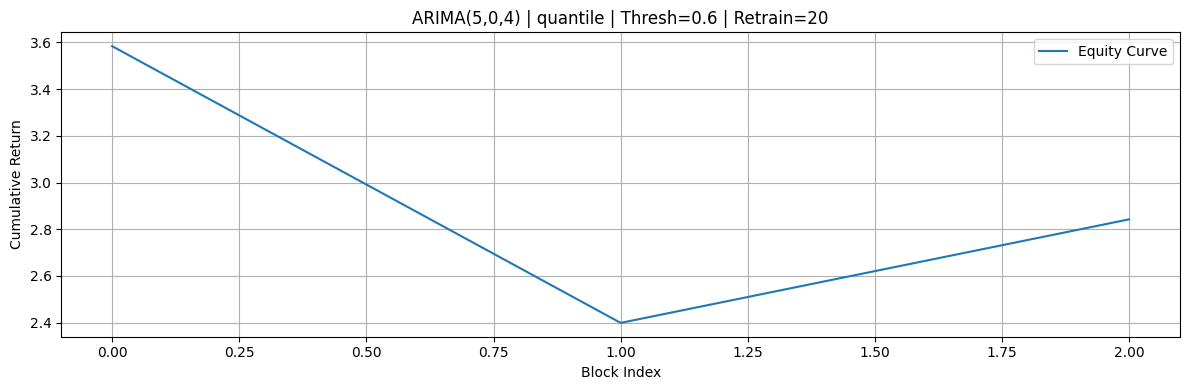

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Block 0-20
Forecast      : [ 0.09701096 -0.18228395 -0.10133514  0.25992904  0.22915213 -0.05444235
 -0.19208186  0.07153582  0.26308351  0.11638344 -0.14730979 -0.08818841
  0.16706241  0.22103938 -0.01244517 -0.14393005  0.01975829  0.21217081
  0.12451191 -0.08800121]
Strategy      : topk
Threshold     : 0.229152
Signals       : [0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sum=3.0
Net returns   : [-0.         -0.          0.          0.24121856  0.15606147 -0.
 -0.         -0.          0.31361055  0.         -0.          0.
  0.          0.         -0.         -0.          0.         -0.
  0.         -0.        ]
Cumulative    : 0.7109


/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Block 20-40
Forecast      : [-0.21544761  0.04215689  0.14713993  0.0046088  -0.16489425 -0.07831062
  0.11281964  0.1099223  -0.06951824 -0.13077069  0.01770151  0.13409008
  0.04000737 -0.10333514 -0.06700841  0.08344078  0.10729775 -0.02440772
 -0.09554314  0.00280588]
Strategy      : topk
Threshold     : 0.112820
Signals       : [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], sum=3.0
Net returns   : [ 0.         -0.         -0.57008255  0.          0.          0.
  0.3166616  -0.         -0.         -0.          0.          0.98036469
  0.          0.          0.         -0.          0.         -0.
 -0.         -0.        ]
Cumulative    : 1.4378

Block 40-42
Forecast      : [0.12715913 0.28284722]
Strategy      : topk
Threshold     : 0.127159
Signals       : [1. 1.], sum=2.0
Net returns   : [-0.16779505  0.44316201]
Cumulative    : 1.7132


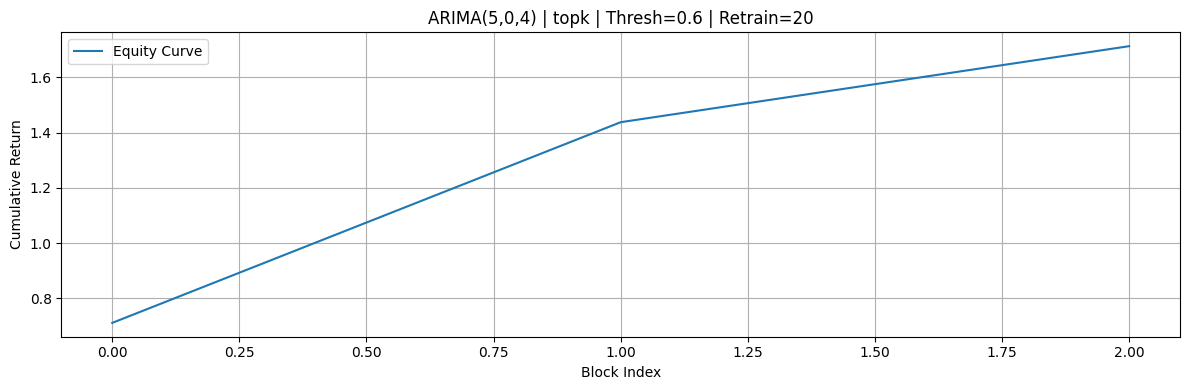

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Block 0-20
Forecast      : [ 0.09701096 -0.18228395 -0.10133514  0.25992904  0.22915213 -0.05444235
 -0.19208186  0.07153582  0.26308351  0.11638344 -0.14730979 -0.08818841
  0.16706241  0.22103938 -0.01244517 -0.14393005  0.01975829  0.21217081
  0.12451191 -0.08800121]
Strategy      : zscore
Threshold     : 0.600000
Signals       : [0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0], sum=6
Net returns   : [-0.         -0.          0.          0.24121856  0.15606147 -0.
 -0.         -0.          0.31361055  0.         -0.          0.
  0.63591579  0.86603564 -0.         -0.          0.         -0.57130246
  0.         -0.        ]
Cumulative    : 1.6415


/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Block 20-40
Forecast      : [-0.21544761  0.04215689  0.14713993  0.0046088  -0.16489425 -0.07831062
  0.11281964  0.1099223  -0.06951824 -0.13077069  0.01770151  0.13409008
  0.04000737 -0.10333514 -0.06700841  0.08344078  0.10729775 -0.02440772
 -0.09554314  0.00280588]
Strategy      : zscore
Threshold     : 0.600000
Signals       : [0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0], sum=6
Net returns   : [ 0.         -0.         -0.57008255  0.          0.          0.
  0.3166616  -1.23806788 -0.         -0.          0.          0.98036469
  0.          0.          0.         -0.57328906  0.36470567 -0.
 -0.         -0.        ]
Cumulative    : 0.9218

Block 40-42
Forecast      : [0.12715913 0.28284722]
Strategy      : zscore
Threshold     : 0.600000
Signals       : [0 1], sum=1
Net returns   : [-0.          0.44316201]
Cumulative    : 1.3650


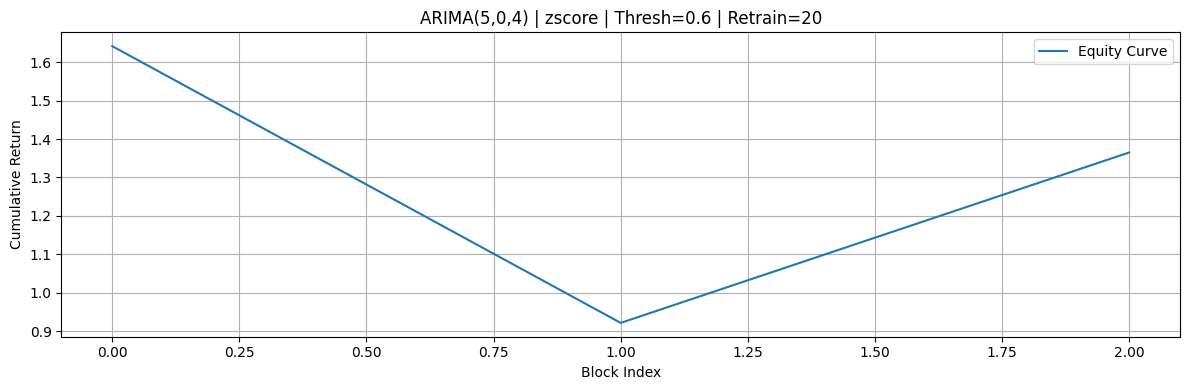

[np.float64(1.6415395428848547),
 np.float64(0.9218319995830341),
 np.float64(1.364994010011834)]

In [ ]:
debug_arima_block(train_ret, val_ret, p=5, q=4, rel_thresh=0.6, strategy='quantile')
debug_arima_block(train_ret, val_ret, p=5, q=4, rel_thresh=0.6, strategy='topk')
debug_arima_block(train_ret, val_ret, p=5, q=4, rel_thresh=0.6, strategy='zscore')

In [1]:
import numpy as np
import pandas as pd

def generate_signal(
    forecast: np.ndarray,
    strategy: str = "zscore",
    cost: float = 0.0007,
    z_thresh: float = 1.0,
    deviation_thresh: float = 0.002,
    window: int = 5,
    multi_step_sum_thresh: float = None
) -> np.ndarray:
    """
    Generate trading signals from forecasted returns.

    Parameters
    ----------
    forecast : np.ndarray
        Array of forecasted returns.
    strategy : str
        One of ["zscore", "rolling_dev", "net_return", "multi_step"].
    cost : float
        Per-trade cost to be considered (e.g., commission + slippage).
    z_thresh : float
        Z-score threshold (used in "zscore" strategy).
    deviation_thresh : float
        Minimum deviation from rolling mean (used in "rolling_dev").
    window : int
        Rolling window size (used in "rolling_dev").
    multi_step_sum_thresh : float
        Threshold for cumulative forecast (used in "multi_step").

    Returns
    -------
    signals : np.ndarray
        Binary array of signals (1 = buy, 0 = no action).
    """

    if strategy == "zscore":
        series = pd.Series(forecast)
        z = (series - series.mean()) / (series.std() + 1e-8)
        return (z > z_thresh).astype(int).values

    elif strategy == "rolling_dev":
        series = pd.Series(forecast)
        rolling = series.rolling(window=window, min_periods=1).mean()
        deviation = series - rolling
        return (deviation > deviation_thresh).astype(int).values

    elif strategy == "net_return":
        net_ret = forecast - cost
        return (net_ret > 0).astype(int)

    elif strategy == "multi_step":
        total_ret = np.sum(forecast)
        if multi_step_sum_thresh is None:
            multi_step_sum_thresh = cost * len(forecast)
        signal = int(total_ret > multi_step_sum_thresh)
        return np.full_like(forecast, signal, dtype=int)

    else:
        raise ValueError(f"Unknown strategy: {strategy}")

In [ ]:
forecast = model.forecast(steps=h)

# Pick your strategy here
signals = generate_signal(
    forecast,
    strategy="zscore",          # Try: "rolling_dev", "net_return", "multi_step"
    cost=cost,
    z_thresh=1.0,
    deviation_thresh=0.002,
    window=5
)

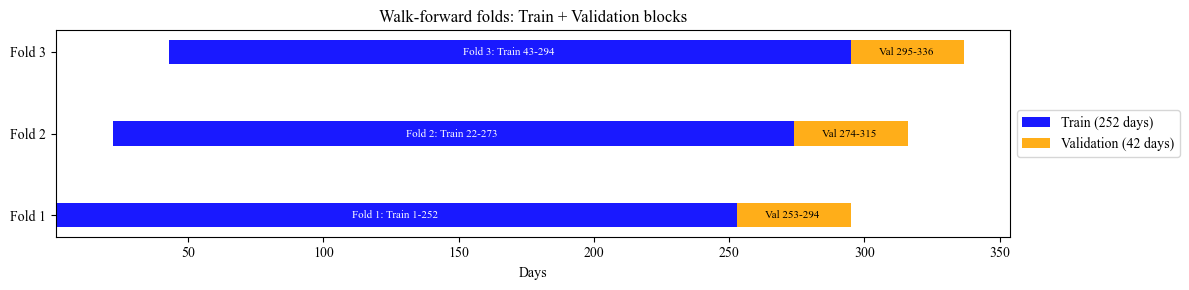

In [18]:
import matplotlib.pyplot as plt

# Example folds data
folds = [
    {"fold": 1, "train": (1, 252), "val": (253, 294)},
    {"fold": 2, "train": (22, 273), "val": (274, 315)},
    {"fold": 3, "train": (43, 294), "val": (295, 336)},
]

fig, ax = plt.subplots(figsize=(12, 3))

for i, f in enumerate(folds, start=1):
    # Train
    ax.barh(y=i, width=f["train"][1] - f["train"][0] + 1,
            left=f["train"][0], color="blue", alpha=0.9, height=0.3, label="Train (252 days)" if i == 1 else "")
    ax.text((f["train"][0] + f["train"][1]) / 2, i,
            f'Fold {f["fold"]}: Train {f["train"][0]}-{f["train"][1]}',
            va="center", ha="center", color="white", fontsize=8)

    # Validation
    ax.barh(y=i, width=f["val"][1] - f["val"][0] + 1,
            left=f["val"][0], color="orange", alpha=0.9, height=0.3, label="Validation (42 days)" if i == 1 else "")
    ax.text((f["val"][0] + f["val"][1]) / 2, i,
            f'Val {f["val"][0]}-{f["val"][1]}',
            va="center", ha="center", color="black", fontsize=8)

# Formatting
ax.set_yticks([1, 2, 3])
ax.set_yticklabels([f"Fold {f['fold']}" for f in folds])
ax.set_xlabel("Days")
ax.set_title("Walk-forward folds: Train + Validation blocks")

# Remove grid
ax.grid(False)

# Legend outside
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [19]:
pip install pandas dataframe-image

Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import dataframe_image as dfi
import os

os.makedirs("data/figures", exist_ok=True)

# Read CSV
df = pd.read_csv("data/raw/AAPL_adjusted.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Select first 2 weeks
start = df["Date"].min()
week = df[(df["Date"] >= start) & (df["Date"] < start + pd.Timedelta(days=14))].copy()

# Format
cols = ["Date", "Open", "High", "Low", "Close", "Volume"]
week = week[cols]
for c in ["Open", "High", "Low", "Close"]:
    week[c] = week[c].map(lambda x: f"{x:,.6f}")
week["Volume"] = week["Volume"].map(lambda x: f"{int(x):,}")

# Style
sty = (
    week.style.hide(axis="index")
        .set_table_styles([
            {"selector": "caption", "props": "caption-side: top; font-size: 14px; font-weight: bold;"},
            {"selector": "th", "props": "background-color: #cce5ff; text-align: center; font-weight: 600;"},
            {"selector": "td", "props": "text-align: center; padding: 6px 10px;"},
            {"selector": "table", "props": "border-collapse: collapse; border: 1px solid #d9d9d9; font-family: Arial, sans-serif; font-size: 11pt;"},
        ])
        .set_properties(**{"border": "1px solid #d9d9d9"})
        .apply(lambda s: ["background-color: #fafbff" if i % 2 else "" for i in range(len(s))], axis=0)
)

# Export AFTER sty is defined
dfi.export(sty, "data/figures/aapl_week_table.png", table_conversion="chrome")

print("Saved -> data/figures/aapl_week_table.png")

Saved -> data/figures/aapl_week_table.png


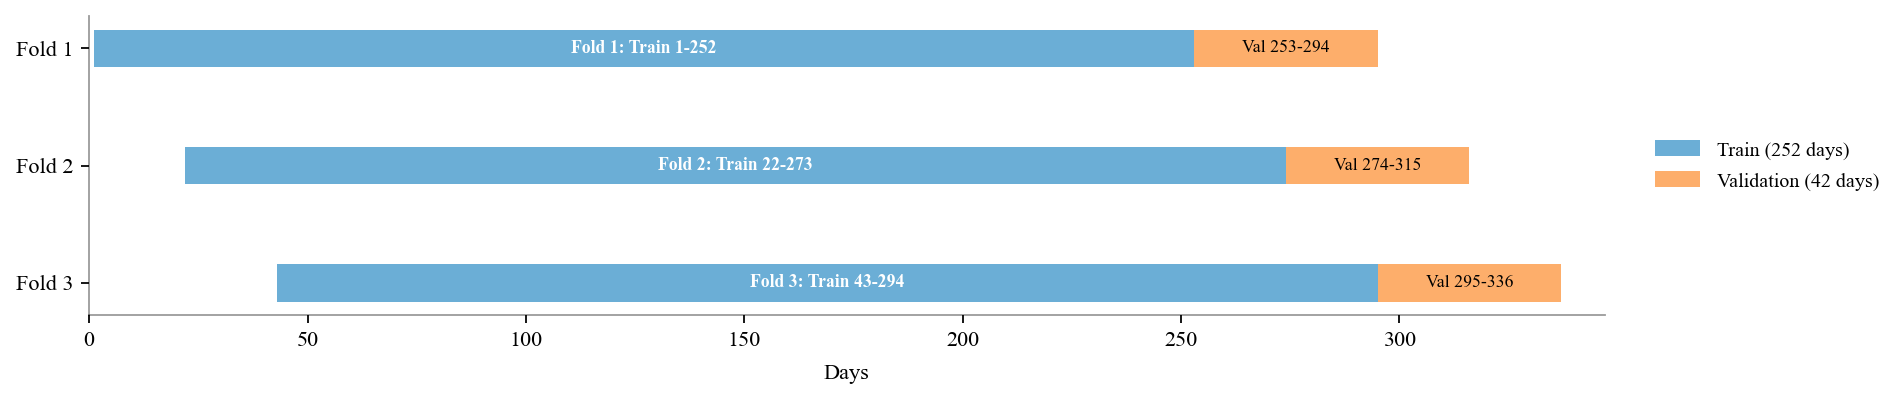

In [22]:
# Walk-forward folds chart (matplotlib)
# -------------------------------------
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# --- Example fold setup (edit as needed) ---
# Each tuple: (fold_label, train_start_day, train_length, val_length)
folds = [
    ("Fold 1", 1,   252, 42),
    ("Fold 2", 22,  252, 42),
    ("Fold 3", 43,  252, 42),
]
plt.rcParams["font.family"] = "Times New Roman"
# Soft, eye-friendly colors
COLOR_TRAIN = "#6baed6"   # light blue
COLOR_VAL   = "#fdae6b"   # light orange

# Axis range (adjust if your horizon differs)
xmax = max(s + tr + vl for _, s, tr, vl in folds) + 10

fig, ax = plt.subplots(figsize=(12, 2.6), dpi=160)

# Vertical positions (top to bottom)
y_positions = list(range(len(folds), 0, -1))

bar_height = 0.32   # a bit thinner looks neat in dissertations

for (label, start, tr_len, val_len), y in zip(folds, y_positions):
    # Train bar
    ax.barh(
        y=y,
        width=tr_len,
        left=start,
        height=bar_height,
        color=COLOR_TRAIN,
        edgecolor="none",
    )
    # Val bar (immediately after train)
    ax.barh(
        y=y,
        width=val_len,
        left=start + tr_len,
        height=bar_height,
        color=COLOR_VAL,
        edgecolor="none",
    )
    # Annotations (centered on each bar)
    ax.text(
        start + tr_len / 2,
        y,
        f"{label}: Train {start}-{start+tr_len-1}",
        va="center",
        ha="center",
        fontsize=8,
        color="white",
        weight="semibold",
    )
    ax.text(
        start + tr_len + val_len / 2,
        y,
        f"Val {start+tr_len}-{start+tr_len+val_len-1}",
        va="center",
        ha="center",
        fontsize=8,
        color="black",
    )

# Y-axis tick labels = fold names (top to bottom)
ax.set_yticks(y_positions)
ax.set_yticklabels([f[0] for f in folds])
ax.set_xlim(0, xmax)

# Styling: remove grid, lighten spines, set labels/title
for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_alpha(0.4)
ax.spines["bottom"].set_alpha(0.4)

ax.set_xlabel("Days", labelpad=6)

# Legend outside (right)
legend_elements = [
    Patch(facecolor=COLOR_TRAIN, label="Train (252 days)"),
    Patch(facecolor=COLOR_VAL,   label="Validation (42 days)"),
]
leg = ax.legend(
    handles=legend_elements,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
)
for text in leg.get_texts():
    text.set_fontsize(9)

plt.tight_layout()
# Optional: save to file
plt.savefig("walkforward_folds.png", bbox_inches="tight", dpi=300)
plt.show()

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

def compute_log_returns(df, price_col="Close"):
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Ticker", "Date"])
    # safe group-wise diff with aligned index
    lr = (
        np.log(df[price_col])
        .groupby(df["Ticker"], sort=False)
        .diff()
        .rename("log_ret")
    )
    df = df.assign(log_ret=lr)
    return df.dropna(subset=["log_ret"])

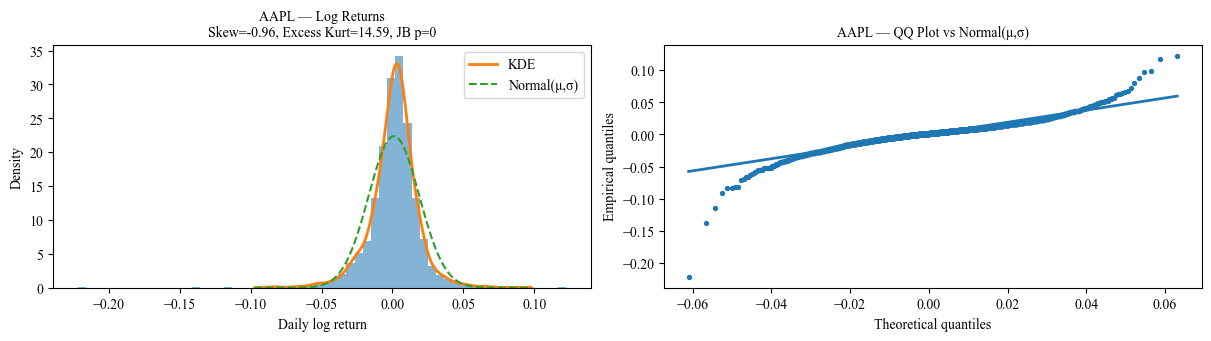

In [25]:
df = pd.read_csv("data/combined/combined_data.csv")
df_lr = compute_log_returns(df)

# keep just one ticker for the dissertation figure (e.g., AAPL)
from scipy import stats
from statsmodels.stats.stattools import jarque_bera

def plot_returns_distribution(df_lr, tickers, bins=60):
    n = len(tickers)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 3.3*n), constrained_layout=True)
    if n == 1:
        axes = np.array([axes])
    for i, tkr in enumerate(tickers):
        r = df_lr.loc[df_lr["Ticker"] == tkr, "log_ret"].dropna().values
        mu, sigma = float(np.mean(r)), float(np.std(r, ddof=1))
        skew = float(stats.skew(r, bias=False))
        ex_kurt = float(stats.kurtosis(r, fisher=True, bias=False))
        jb_stat, jb_p, _, _ = jarque_bera(r)

        # Histogram + KDE + Normal fit
        axh = axes[i, 0]
        axh.hist(r, bins=bins, density=True, alpha=0.55)
        xs = np.linspace(np.percentile(r, 0.1), np.percentile(r, 99.9), 400)
        kde = stats.gaussian_kde(r)
        axh.plot(xs, kde(xs), lw=2, label="KDE")
        axh.plot(xs, stats.norm.pdf(xs, loc=mu, scale=sigma), lw=1.5, ls="--", label="Normal(μ,σ)")
        axh.set_title(f"{tkr} — Log Returns\nSkew={skew:.2f}, Excess Kurt={ex_kurt:.2f}, JB p={jb_p:.3g}", fontsize=10)
        axh.set_xlabel("Daily log return"); axh.set_ylabel("Density"); axh.legend()

        # QQ-plot vs Normal(μ,σ)
        axq = axes[i, 1]
        (osm, osr), (slope, intercept, r_) = stats.probplot(r, dist=stats.norm, sparams=(mu, sigma))
        axq.scatter(osm, osr, s=8)
        axq.plot(osm, slope*osm + intercept, lw=2)
        axq.set_title(f"{tkr} — QQ Plot vs Normal(μ,σ)", fontsize=10)
        axq.set_xlabel("Theoretical quantiles"); axq.set_ylabel("Empirical quantiles")

    #fig.suptitle("Distributional Properties of Daily Log Returns\n(Histogram+KDE+Normal Fit and QQ-Plot)", y=1.02)
    plt.show()

plot_returns_distribution(df_lr, ["AAPL"])

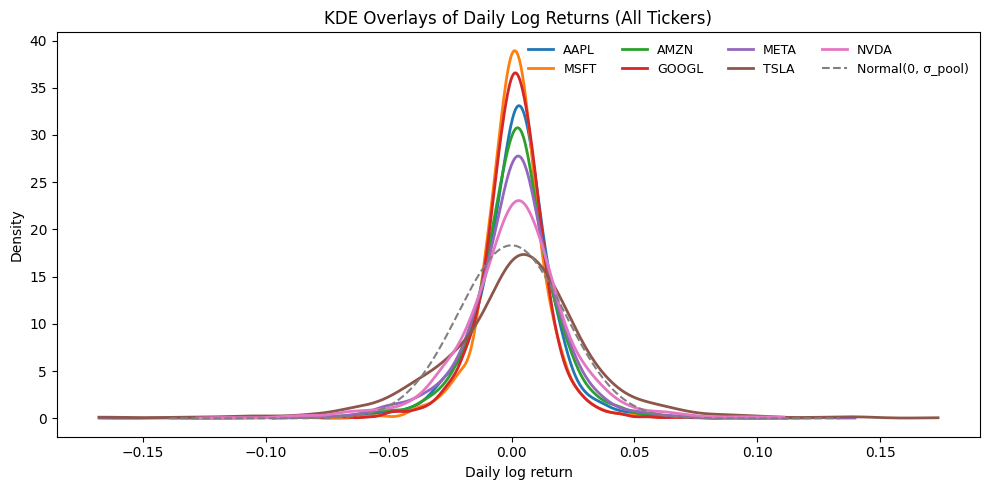

In [20]:
def overlay_kde_all_tickers(df_lr, tickers, bins=120, bandwidth=None):
    plt.figure(figsize=(10, 5))
    colors = plt.cm.tab10.colors  # distinct but not flashy
    x_all = []

    for i, tkr in enumerate(tickers):
        r = df_lr.loc[df_lr["Ticker"] == tkr, "log_ret"].dropna().values
        if r.size < 10: 
            continue
        x_all.append(r)
        kde = stats.gaussian_kde(r) if bandwidth is None else stats.gaussian_kde(r, bw_method=bandwidth)
        xs = np.linspace(np.percentile(r, 0.1), np.percentile(r, 99.9), 500)
        plt.plot(xs, kde(xs), label=tkr, lw=2, color=colors[i % len(colors)])

    # Draw a light normal N(0,σ_pool) for reference
    pooled = np.concatenate(x_all)
    sig = np.std(pooled, ddof=1)
    xs_ref = np.linspace(np.percentile(pooled, 0.1), np.percentile(pooled, 99.9), 500)
    plt.plot(xs_ref, stats.norm.pdf(xs_ref, 0.0, sig), ls="--", lw=1.5, color="gray", label="Normal(0, σ_pool)")

    plt.title("KDE Overlays of Daily Log Returns (All Tickers)")
    plt.xlabel("Daily log return"); plt.ylabel("Density")
    plt.legend(ncol=4, fontsize=9, frameon=False)
    plt.tight_layout()
    plt.show()

overlay_kde_all_tickers(df_lr, ["AAPL","MSFT","AMZN","GOOGL","META","TSLA","NVDA"])

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import jarque_bera

import matplotlib.pyplot as plt
from matplotlib import font_manager

# ---------- 1) Make the diagnostics table (plain, sorted, formatted) ----------
def tail_diagnostic_table(df, tickers, sort_by="Excess Kurtosis", ascending=False):
    rows = []
    for tkr in tickers:
        r = df.loc[df["Ticker"] == tkr, "log_ret"].dropna().values
        if r.size < 10:
            continue
        jb_stat, jb_p = jarque_bera(r)
        rows.append({
            "Ticker": tkr,
            "Mean": np.mean(r),
            "Std": np.std(r, ddof=1),
            "Skewness": stats.skew(r, bias=False),
            "Excess Kurtosis": stats.kurtosis(r, fisher=True, bias=False),
            "JB p-value": jb_p
        })

    tbl = pd.DataFrame(rows)
    if sort_by in tbl.columns:
        tbl = tbl.sort_values(sort_by, ascending=ascending).reset_index(drop=True)

    # format p-values and round numbers
    def fmt_p(p): return "< 0.001" if p < 1e-3 else f"{p:.3f}"
    tidy = tbl.copy()
    tidy["Mean"] = tidy["Mean"].round(6)
    tidy["Std"] = tidy["Std"].round(6)
    tidy["Skewness"] = tidy["Skewness"].round(4)
    tidy["Excess Kurtosis"] = tidy["Excess Kurtosis"].round(3)
    tidy["JB p-value"] = tidy["JB p-value"].map(fmt_p)
    return tidy

# ---------- 2) Render the table to SVG with Times New Roman ----------
def render_table_png(df, out_path,
                     title="Table 4.X Distributional diagnostics of daily log returns (2010–2020)",
                     header_bg="#003D78", header_fg="white",
                     body_fs=10, header_fs=11, row_h=0.28, header_h=0.34,
                     dpi=600):
    """
    Save a publication-friendly table as high-resolution PNG. Uses Times New Roman.
    """
    import matplotlib.pyplot as plt
    from matplotlib import font_manager

    # Thiết lập font Times New Roman
    have_tnr = any("Times New Roman" in f.name for f in font_manager.fontManager.ttflist)
    plt.rcParams["font.family"] = "Times New Roman" if have_tnr else "DejaVu Serif"

    n_rows, n_cols = df.shape
    fig_w = 0.6 + n_cols * 1.35
    fig_h = 0.5 + header_h + n_rows * row_h + 0.2

    fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=dpi)
    ax.axis("off")

    # Tạo table
    tbl = ax.table(cellText=df.values.tolist(),
                   colLabels=list(df.columns),
                   loc="upper left",
                   cellLoc="center")

    tbl.auto_set_font_size(False)

    # Style
    for (r, c), cell in tbl.get_celld().items():
        if r == 0:
            cell.set_facecolor(header_bg)
            cell.set_text_props(color=header_fg, fontsize=header_fs, weight="bold")
            cell.set_height(header_h)
        else:
            cell.set_facecolor("#F8FBFF" if r % 2 == 0 else "white")
            cell.set_text_props(fontsize=body_fs)
            cell.set_height(row_h)
        cell.set_edgecolor("#D2DCEB")

    #ax.set_title(title, fontsize=12, weight="bold", pad=10)

    plt.tight_layout()
    fig.savefig(out_path, format="png", dpi=dpi, bbox_inches="tight")  # PNG với dpi cao
    plt.close(fig)


df = pd.read_csv("data/combined/combined_data.csv")
df_lr = compute_log_returns(df)

tidy_tbl = tail_diagnostic_table(df_lr, ["AAPL","MSFT","AMZN","GOOGL","META","TSLA","NVDA"],
                                 sort_by="Excess Kurtosis", ascending=False)
render_table_png(tidy_tbl, "table_4X_distributional_diagnostics.png", dpi=600)
tidy_tbl.to_csv("table_4X_distributional_diagnostics.csv", index=False)   # optional appendix export

/var/folders/6d/n0c7d2jd30sb50l09f4d_qsm0000gn/T/ipykernel_3329/2820265251.py:85: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


In [1]:
# --- CONFIG ---
DATA_PATH = "data/combined/combined_data.csv"
TICKERS   = ["AAPL","MSFT","AMZN","GOOGL","META","NFLX","TSLA"]  # 7 tickers
ROLL_WIN  = 252
FIG_DIR   = "figures"   # ảnh sẽ lưu trong figures/<ticker>/

# --- Imports ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.sm_exceptions import InterpolationWarning
import warnings
warnings.simplefilter("ignore", InterpolationWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)

os.makedirs(FIG_DIR, exist_ok=True)

# --- Load once ---
df = pd.read_csv(DATA_PATH)
need = {"Date","Ticker","Close"}
if not need.issubset(df.columns):
    raise ValueError(f"CSV phải có tối thiểu các cột: {need}")

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.sort_values(["Ticker","Date"]).dropna(subset=["Date","Ticker","Close"])

# --- Helpers ---
def run_adf(series):
    stat, pval, lags, nobs, *_ = adfuller(series, autolag="AIC")
    return stat, pval, lags, nobs

def run_kpss_level(series):
    stat, pval, lags, *_ = kpss(series, regression="c", nlags="auto")
    return stat, pval, lags

def plot_save(fig, path):
    fig.tight_layout()
    fig.savefig(path, dpi=180, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved: {path}")

# --- Run per ticker ---
rows = []
for tk in TICKERS:
    sub = (df.loc[df["Ticker"] == tk, ["Date","Close"]]
             .dropna()
             .copy())
    if sub.empty:
        print(f"[WARN] Không có dữ liệu cho {tk}, bỏ qua.")
        continue

    # build series
    sub["log_price"] = np.log(sub["Close"])
    sub["log_ret"]   = sub["log_price"].diff()
    sub = sub.dropna(subset=["log_ret"])
    if sub.empty:
        print(f"[WARN] Không đủ dữ liệu return cho {tk}, bỏ qua.")
        continue

    # stationarity tests
    adf_price  = run_adf(sub["log_price"])
    kpss_price = run_kpss_level(sub["log_price"])
    adf_ret    = run_adf(sub["log_ret"])
    kpss_ret   = run_kpss_level(sub["log_ret"])

    rows.extend([
        {"Ticker": tk, "Series": "Log Price (level)",
         "ADF_stat": adf_price[0], "ADF_p": adf_price[1],
         "KPSS_stat": kpss_price[0], "KPSS_p": kpss_price[1],
         "N_obs": int(adf_price[3])},
        {"Ticker": tk, "Series": "Log Return (diff)",
         "ADF_stat": adf_ret[0], "ADF_p": adf_ret[1],
         "KPSS_stat": kpss_ret[0], "KPSS_p": kpss_ret[1],
         "N_obs": int(adf_ret[3])},
    ])

    # figure dir per ticker
    outdir = os.path.join(FIG_DIR, tk)
    os.makedirs(outdir, exist_ok=True)

    # Plot 1: Price level
    fig, ax = plt.subplots(figsize=(9,3.2))
    ax.plot(sub["Date"], sub["Close"])
    ax.set_title(f"{tk} — Price Level (Close)")
    ax.set_xlabel("Date"); ax.set_ylabel("Price")
    plot_save(fig, os.path.join(outdir, f"{tk}_price_level.png"))

    # Plot 2: Log returns
    fig, ax = plt.subplots(figsize=(9,3.2))
    ax.plot(sub["Date"], sub["log_ret"])
    ax.set_title(f"{tk} — Daily Log Returns")
    ax.set_xlabel("Date"); ax.set_ylabel("Log return")
    plot_save(fig, os.path.join(outdir, f"{tk}_log_returns.png"))

    # Plot 3: Rolling mean
    fig, ax = plt.subplots(figsize=(9,3.2))
    ax.plot(sub["Date"], sub["log_ret"].rolling(ROLL_WIN).mean())
    ax.set_title(f"{tk} — Rolling Mean of Log Returns ({ROLL_WIN}d)")
    ax.set_xlabel("Date"); ax.set_ylabel("Rolling mean")
    plot_save(fig, os.path.join(outdir, f"{tk}_rolling_mean_{ROLL_WIN}d.png"))

    # Plot 4: Rolling variance
    fig, ax = plt.subplots(figsize=(9,3.2))
    ax.plot(sub["Date"], sub["log_ret"].rolling(ROLL_WIN).var())
    ax.set_title(f"{tk} — Rolling Variance of Log Returns ({ROLL_WIN}d)")
    ax.set_xlabel("Date"); ax.set_ylabel("Rolling variance")
    plot_save(fig, os.path.join(outdir, f"{tk}_rolling_variance_{ROLL_WIN}d.png"))

    # Seasonal decomposition from log price (additive)
    try:
        ser = sub.set_index("Date")["log_price"]
        decomp = seasonal_decompose(ser, model="additive", period=ROLL_WIN)

        fig, ax = plt.subplots(figsize=(9,3.2))
        ax.plot(decomp.trend.index, decomp.trend.values)
        ax.set_title(f"{tk} — Decomposition: Trend (from log price)")
        ax.set_xlabel("Date"); ax.set_ylabel("Trend")
        plot_save(fig, os.path.join(outdir, f"{tk}_decomp_trend.png"))

        fig, ax = plt.subplots(figsize=(9,3.2))
        ax.plot(decomp.seasonal.index, decomp.seasonal.values)
        ax.set_title(f"{tk} — Decomposition: Seasonal (from log price)")
        ax.set_xlabel("Date"); ax.set_ylabel("Seasonal")
        plot_save(fig, os.path.join(outdir, f"{tk}_decomp_seasonal.png"))
    except Exception as e:
        print(f"[Note] {tk}: bỏ qua seasonal decomposition ({e}). "
              "Cần chuỗi đủ dài (~>= 2*period) và dữ liệu đều.")

# --- Combined summary table ---
if rows:
    summary = pd.DataFrame(rows).round(4)
    out_csv = os.path.join(FIG_DIR, "stationarity_summary.csv")
    summary.to_csv(out_csv, index=False)
    print(f"\n[OK] Saved stationarity summary -> {out_csv}")
    print(summary)
else:
    print("[WARN] Không có ticker nào tạo được kết quả.")

Saved: figures/AAPL/AAPL_price_level.png
Saved: figures/AAPL/AAPL_log_returns.png
Saved: figures/AAPL/AAPL_rolling_mean_252d.png
Saved: figures/AAPL/AAPL_rolling_variance_252d.png
Saved: figures/AAPL/AAPL_decomp_trend.png
Saved: figures/AAPL/AAPL_decomp_seasonal.png
Saved: figures/MSFT/MSFT_price_level.png
Saved: figures/MSFT/MSFT_log_returns.png
Saved: figures/MSFT/MSFT_rolling_mean_252d.png
Saved: figures/MSFT/MSFT_rolling_variance_252d.png
Saved: figures/MSFT/MSFT_decomp_trend.png
Saved: figures/MSFT/MSFT_decomp_seasonal.png
Saved: figures/AMZN/AMZN_price_level.png
Saved: figures/AMZN/AMZN_log_returns.png
Saved: figures/AMZN/AMZN_rolling_mean_252d.png
Saved: figures/AMZN/AMZN_rolling_variance_252d.png
Saved: figures/AMZN/AMZN_decomp_trend.png
Saved: figures/AMZN/AMZN_decomp_seasonal.png
Saved: figures/GOOGL/GOOGL_price_level.png
Saved: figures/GOOGL/GOOGL_log_returns.png
Saved: figures/GOOGL/GOOGL_rolling_mean_252d.png
Saved: figures/GOOGL/GOOGL_rolling_variance_252d.png
Saved: figu

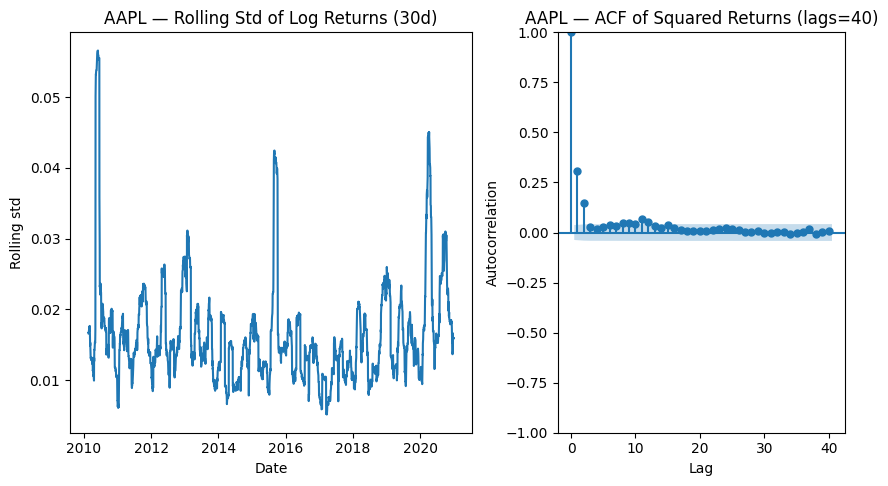

Saved appendix figures to: figures/vol_clustering


In [ ]:
# --- Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# --- Config
CSV_PATH = "data/combined/combined_data.csv"   # columns: Date, Ticker, Close (at minimum)
MAIN_TICKER = "AAPL"                            # shown inline in Chapter 4
APPX_TICKERS = ["MSFT", "TSLA", "NVDA"]        # optional robustness figs for Appendix
ROLL_WINDOW = 30                                # days
ACF_LAGS = 40
OUTDIR = "figures/vol_clustering"
os.makedirs(OUTDIR, exist_ok=True)

# --- Load & compute daily log returns
df = pd.read_csv(CSV_PATH)
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Ticker", "Date"]).reset_index(drop=True)
df["log_ret"] = np.log(df["Close"]).groupby(df["Ticker"]).diff()
df = df.dropna(subset=["log_ret"])

def plot_vol_clustering(df_lr: pd.DataFrame, ticker: str,
                        roll_window: int = 30, acf_lags: int = 40,
                        savepath: str | None = None, show: bool = True):
    """Draw rolling std of log returns and ACF of squared returns for one ticker."""
    sub = df_lr[df_lr["Ticker"] == ticker].copy()
    if sub.empty:
        raise ValueError(f"No data for ticker: {ticker}")

    sub = sub.sort_values("Date")
    sub["roll_std"] = sub["log_ret"].rolling(roll_window).std()
    sq = (sub["log_ret"]**2).dropna()

    # --- Figure
    fig = plt.figure(figsize=(10, 5.2))
    gs = fig.add_gridspec(1, 2, width_ratios=[1.4, 1], wspace=0.25)

    # (A) Rolling standard deviation
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(sub["Date"], sub["roll_std"], linewidth=1.5)
    ax1.set_title(f"{ticker} — Rolling Std of Log Returns ({roll_window}d)")
    ax1.set_xlabel("Date"); ax1.set_ylabel("Rolling std")

    # (B) ACF of squared returns
    ax2 = fig.add_subplot(gs[0, 1])
    plot_acf(sq, lags=acf_lags, ax=ax2)
    ax2.set_title(f"{ticker} — ACF of Squared Returns (lags={acf_lags})")
    ax2.set_xlabel("Lag"); ax2.set_ylabel("Autocorrelation")

    fig.suptitle("Volatility Clustering Diagnostics", y=1.02, fontsize=12)
    fig.tight_layout()

    if savepath:
        fig.savefig(savepath, dpi=200, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close(fig)

# ---- 1) Inline figure for the main text (AAPL)
plot_vol_clustering(df, MAIN_TICKER, roll_window=ROLL_WINDOW, acf_lags=ACF_LAGS)

# ---- 2) Batch export for appendix (set show=False to skip inline display)
for tkr in APPX_TICKERS:
    out = os.path.join(OUTDIR, f"vol_clustering_{tkr}.png")
    plot_vol_clustering(df, tkr, roll_window=ROLL_WINDOW, acf_lags=ACF_LAGS,
                        savepath=out, show=False)
print(f"Saved appendix figures to: {OUTDIR}")

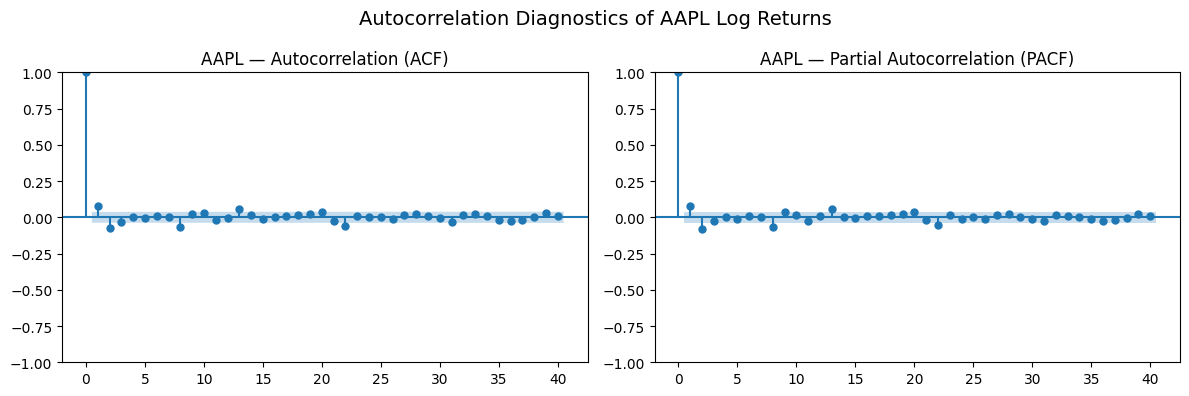

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example: AAPL returns
df = pd.read_csv("data/combined/combined_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Ticker'] == 'AAPL'].sort_values('Date')
df['log_ret'] = np.log(df['Close']).diff().dropna()

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(df['log_ret'].dropna(), lags=40, ax=axes[0])
axes[0].set_title("AAPL — Autocorrelation (ACF)")

plot_pacf(df['log_ret'].dropna(), lags=40, ax=axes[1])
axes[1].set_title("AAPL — Partial Autocorrelation (PACF)")
fig.suptitle("Autocorrelation Diagnostics of AAPL Log Returns", fontsize=14)

plt.tight_layout()
plt.show()

/var/folders/6d/n0c7d2jd30sb50l09f4d_qsm0000gn/T/ipykernel_2494/4163614333.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


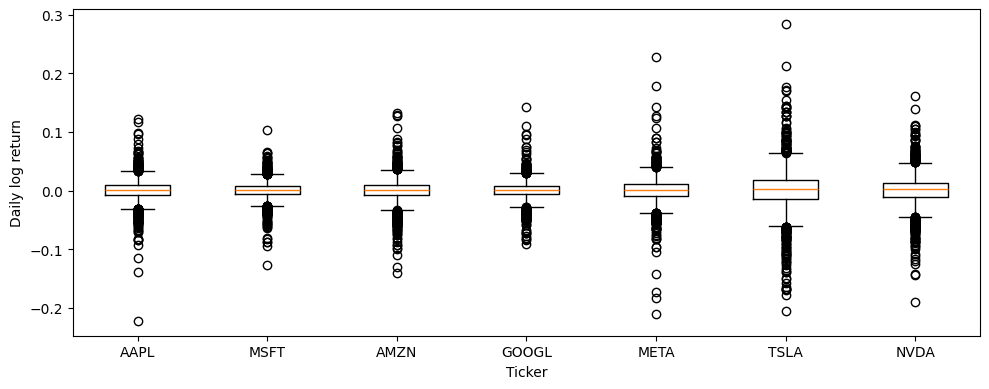

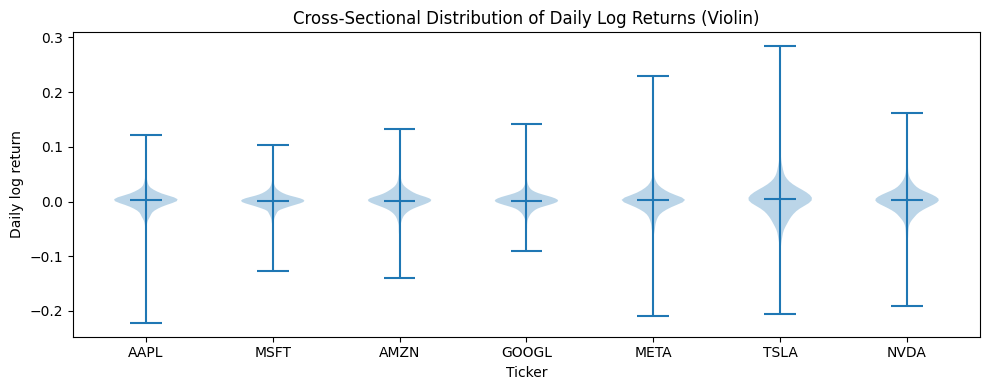

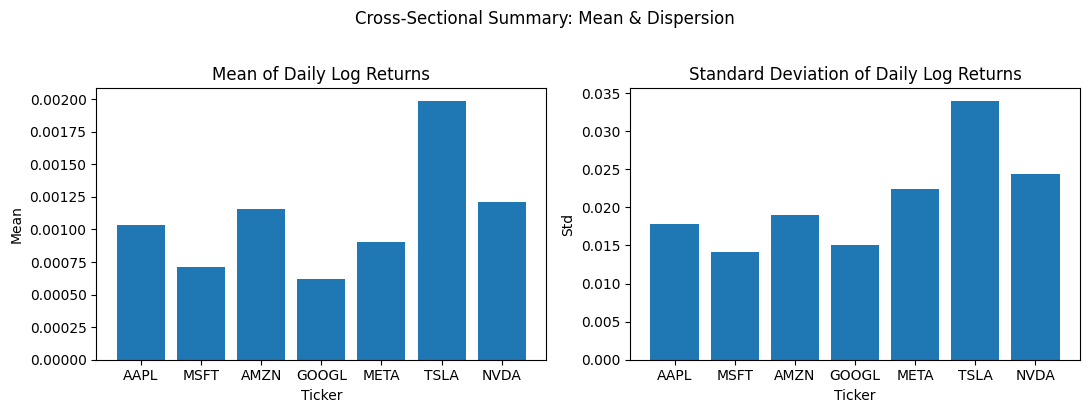

Saved:
 - figures/cross_section_boxplot_log_returns.png
 - figures/cross_section_violin_log_returns.png
 - figures/cross_section_mean_std_log_returns.png


In [7]:
# --- Cross-sectional visuals for Magnificent Seven ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------- Inputs ---------
csv_path = "data/combined/combined_data.csv"   # expects columns: Date, Ticker, Close (at least)
tickers  = ["AAPL","MSFT","AMZN","GOOGL","META","TSLA","NVDA"]
outdir   = "figures"
os.makedirs(outdir, exist_ok=True)

# --------- Load & compute daily log returns ---------
# --- Load & compute daily log returns (index-safe) ---
df = pd.read_csv("data/combined/combined_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Ticker", "Date"]).reset_index(drop=True)

# Ensure Close is numeric and positive
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df = df[df["Close"] > 0].copy()

# Index-preserving computation:
df["log_close"] = np.log(df["Close"])
df["log_ret"]   = df.groupby("Ticker")["log_close"].diff()

# If you prefer a one-liner that also preserves index:
# df["log_ret"] = np.log(df["Close"]).groupby(df["Ticker"]).diff()

# Drop the initial NaN per ticker created by diff
df_lr = df.dropna(subset=["log_ret"]).copy()

# utility: list of arrays in ticker order for box/violin
data_by_ticker = [df_lr.loc[df_lr["Ticker"] == t, "log_ret"].values for t in tickers]

# --------- (1) Boxplot ---------
plt.figure(figsize=(10,4))
plt.boxplot(
    data_by_ticker,
    labels=tickers,
    showfliers=True,   # keep outliers visible
    whis=1.5
)
plt.xlabel("Ticker")
plt.ylabel("Daily log return")
#plt.title("Cross-Sectional Distribution of Daily Log Returns (Boxplot)")
plt.tight_layout()
box_path = os.path.join(outdir, "cross_section_boxplot_log_returns.png")
plt.savefig(box_path, dpi=300, bbox_inches="tight")
plt.show()

# --------- (2) Violin plot (density shape) ---------
plt.figure(figsize=(10,4))
parts = plt.violinplot(
    data_by_ticker,
    showmeans=False,
    showmedians=True,
    showextrema=True
)
# x-axis tick labels
plt.xticks(range(1, len(tickers)+1), tickers)
plt.xlabel("Ticker")
plt.ylabel("Daily log return")
plt.title("Cross-Sectional Distribution of Daily Log Returns (Violin)")
plt.tight_layout()
vio_path = os.path.join(outdir, "cross_section_violin_log_returns.png")
plt.savefig(vio_path, dpi=300, bbox_inches="tight")
plt.show()

# --------- (3) Summary bars: mean & std (optional) ---------
summary = (df_lr.groupby("Ticker")["log_ret"]
           .agg(mean="mean", std=lambda x: np.std(x, ddof=1))
           .reindex(tickers))

fig, ax = plt.subplots(1, 2, figsize=(11,4), sharex=False)
ax[0].bar(summary.index, summary["mean"].values)
ax[0].set_title("Mean of Daily Log Returns")
ax[0].set_xlabel("Ticker")
ax[0].set_ylabel("Mean")

ax[1].bar(summary.index, summary["std"].values)
ax[1].set_title("Standard Deviation of Daily Log Returns")
ax[1].set_xlabel("Ticker")
ax[1].set_ylabel("Std")

fig.suptitle("Cross-Sectional Summary: Mean & Dispersion", y=1.02)
plt.tight_layout()
bar_path = os.path.join(outdir, "cross_section_mean_std_log_returns.png")
plt.savefig(bar_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:")
print(" -", box_path)
print(" -", vio_path)
print(" -", bar_path)

In [9]:
pip install statsmodels arch

Note: you may need to restart the kernel to use updated packages.


/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003139. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


=== Diagnostics (Normal innovations) ===
      lb_mean_stat: 30.518245897517176
         lb_mean_p: 0.061880207308145536
       lb_var_stat: 15.203063505693795
          lb_var_p: 0.7646727138334842
      arch_lm_stat: 15.384417834303648
         arch_lm_p: 0.7540048711965289
           jb_stat: 8273.064861062709
              jb_p: 0.0
              skew: -0.9611357629482522
   excess_kurtosis: 11.250004391355361
           ad_stat: 31.340477261224805
              ad_p: 0.0


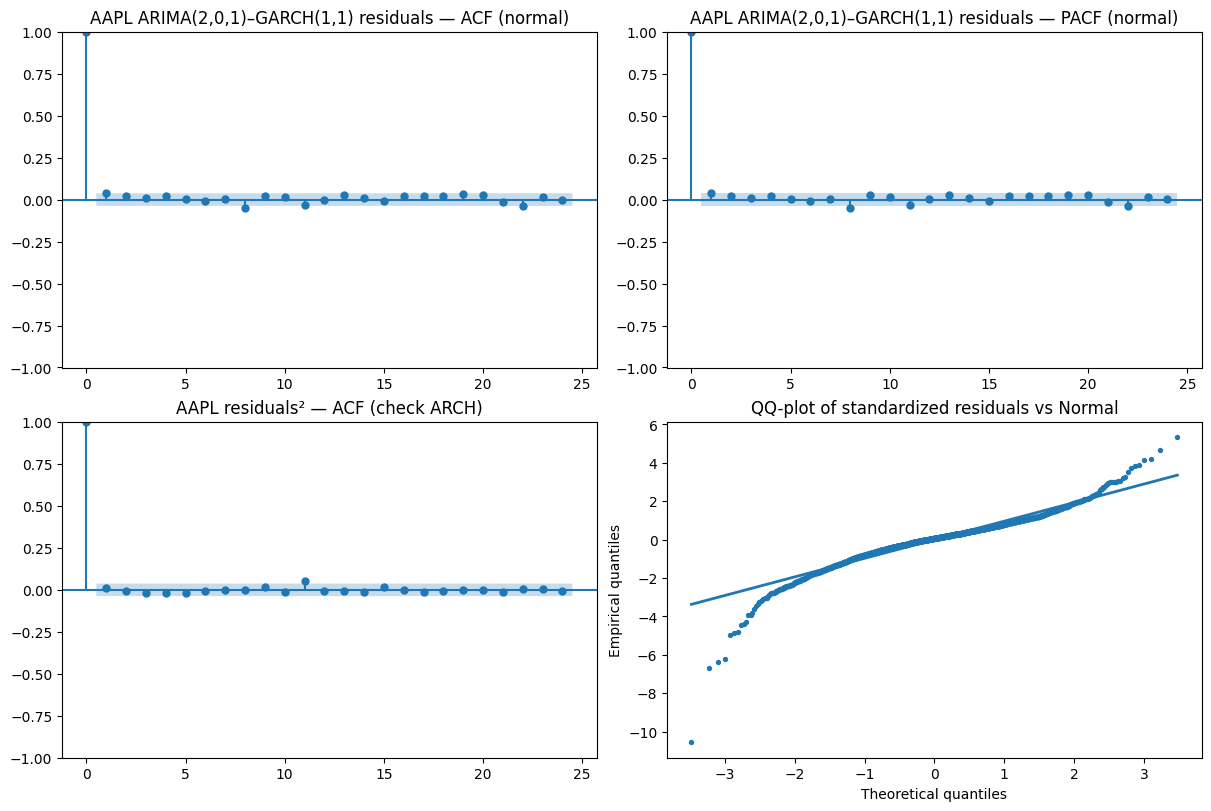

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003139. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Diagnostics (Student-t innovations) ===
      lb_mean_stat: 30.733797278408893
         lb_mean_p: 0.058804290074530106
       lb_var_stat: 14.296444519368588
          lb_var_p: 0.8151530235349445
      arch_lm_stat: 14.721994977462472
         arch_lm_p: 0.7920879469053496
           jb_stat: 10024.61697339422
              jb_p: 0.0
              skew: -1.0152867985360658
   excess_kurtosis: 12.100924554003194
           ad_stat: 31.841726180784008
              ad_p: 0.0


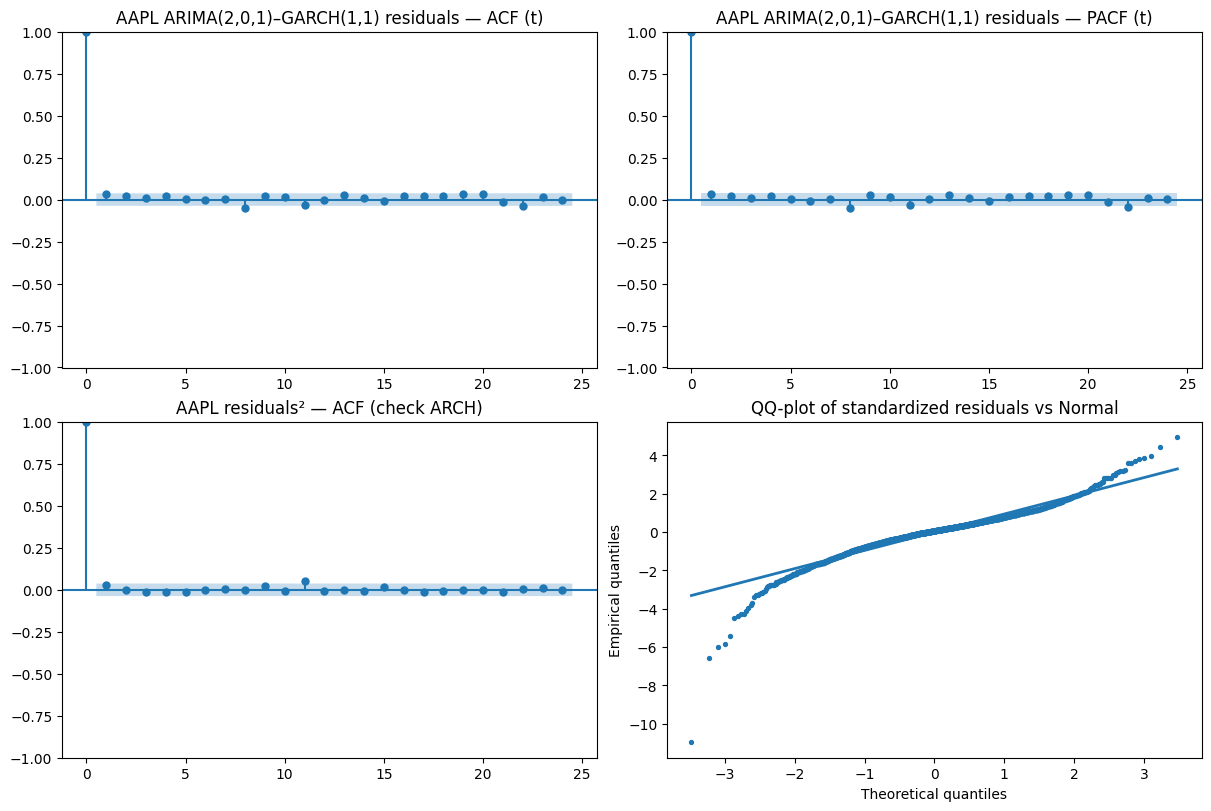

In [10]:
# --- Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import normal_ad
from scipy import stats

# ---------------------------
# Utilities
# ---------------------------
def compute_log_returns(df, price_col="Close"):
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Ticker", "Date"])
    # groupby().apply returns misaligned index if not careful; use transform
    df["log_ret"] = df.groupby("Ticker")[price_col].transform(lambda s: np.log(s).diff())
    return df.dropna(subset=["log_ret"])

def fit_arima_garch(log_ret, p=1, q=1, garch_dist="normal", verbose=False):
    """
    Fit ARIMA(p,0,q) to mean and GARCH(1,1) to residuals. Returns dict with fits & residuals.
    garch_dist in {"normal","t"}.
    """
    # ARIMA mean
    arima_res = ARIMA(log_ret, order=(p, 0, q)).fit()

    resid = np.asarray(arima_res.resid, dtype=float)
    # GARCH on ARIMA residuals
    am = arch_model(resid, mean="Zero", vol="Garch", p=1, q=1, dist=garch_dist)
    garch_res = am.fit(disp="off")

    # Standardized residuals from volatility fit
    # sigma_t: conditional volatility; std resid: resid / sigma_t
    cond_var = garch_res.conditional_volatility
    std_resid = resid[-cond_var.shape[0]:] / (cond_var + 1e-12)

    if verbose:
        print(arima_res.summary())
        print(garch_res.summary())

    return {
        "arima": arima_res,
        "garch": garch_res,
        "resid": resid,
        "std_resid": np.asarray(std_resid, dtype=float)
    }

def diagnostic_tests(std_resid, lags=20):
    """
    Standard tests on standardized residuals.
    """
    std_resid = np.asarray(std_resid, dtype=float)
    std_resid = std_resid[np.isfinite(std_resid)]

    # Ljung–Box on residuals (mean autocorr)
    lb_mean = acorr_ljungbox(std_resid, lags=[lags], return_df=True)

    # Ljung–Box on squared residuals (remaining ARCH)
    lb_var  = acorr_ljungbox(std_resid**2, lags=[lags], return_df=True)

    # Engle's ARCH LM test
    # Null: no ARCH effects. If p<0.05 -> ARCH present (bad).
    arch_lm_stat, arch_lm_p, _, _ = het_arch(std_resid, nlags=lags)

    # Normality: Jarque–Bera, Anderson–Darling
    jb_stat, jb_p, skew, ex_kurt = jarque_bera(std_resid)
    ad_stat, ad_p = normal_ad(std_resid)

    return {
        "lb_mean_stat": float(lb_mean["lb_stat"].iloc[0]),
        "lb_mean_p": float(lb_mean["lb_pvalue"].iloc[0]),
        "lb_var_stat": float(lb_var["lb_stat"].iloc[0]),
        "lb_var_p": float(lb_var["lb_pvalue"].iloc[0]),
        "arch_lm_stat": float(arch_lm_stat),
        "arch_lm_p": float(arch_lm_p),
        "jb_stat": float(jb_stat),
        "jb_p": float(jb_p),
        "skew": float(skew),
        "excess_kurtosis": float(ex_kurt),
        "ad_stat": float(ad_stat),
        "ad_p": float(ad_p),
    }

def diagnostic_plots(std_resid, ticker="TICKER", p=1, q=1, dist="normal", lags=24):
    """
    ACF/PACF of residuals and squared residuals + QQ plot.
    """
    std_resid = np.asarray(std_resid, dtype=float)
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

    # ACF/PACF of standard residuals
    plot_acf(std_resid, lags=lags, ax=axes[0,0])
    axes[0,0].set_title(f"{ticker} ARIMA({p},0,{q})–GARCH(1,1) residuals — ACF ({dist})")
    plot_pacf(std_resid, lags=lags, ax=axes[0,1], method="ywm")
    axes[0,1].set_title(f"{ticker} ARIMA({p},0,{q})–GARCH(1,1) residuals — PACF ({dist})")

    # ACF of squared residuals
    plot_acf(std_resid**2, lags=lags, ax=axes[1,0])
    axes[1,0].set_title(f"{ticker} residuals² — ACF (check ARCH)")

    # QQ plot vs Normal
    osm, osr = stats.probplot(std_resid, dist="norm")[:2]
    x = osm[0]; y = osm[1]
    slope, intercept, _ = osr
    axes[1,1].scatter(x, y, s=8)
    axes[1,1].plot(x, slope*x + intercept, lw=2)
    axes[1,1].set_title("QQ-plot of standardized residuals vs Normal")
    axes[1,1].set_xlabel("Theoretical quantiles")
    axes[1,1].set_ylabel("Empirical quantiles")

    plt.show()

# ---------------------------
# Example usage
# ---------------------------
# 1) Load your combined daily data with columns: Date, Ticker, Close
df = pd.read_csv("data/combined/combined_data.csv")

# 2) Compute log returns
df_lr = compute_log_returns(df, price_col="Close")

# 3) Choose one ticker (e.g., AAPL) and drop NaNs/infs
tkr = "AAPL"
r = df_lr.loc[df_lr["Ticker"] == tkr, "log_ret"].replace([np.inf, -np.inf], np.nan).dropna().values

# 4) Fit ARIMA–GARCH with Normal innovations
p, q = 2, 1   # <-- set the orders you want to diagnose
fit_norm = fit_arima_garch(r, p=p, q=q, garch_dist="normal", verbose=False)

# 5) Diagnostics (Normal)
tests_norm = diagnostic_tests(fit_norm["std_resid"], lags=20)
print("=== Diagnostics (Normal innovations) ===")
for k, v in tests_norm.items():
    print(f"{k:>18s}: {v}")

diagnostic_plots(fit_norm["std_resid"], ticker=tkr, p=p, q=q, dist="normal", lags=24)

# 6) (Optional) Re-fit with Student-t innovations to check fat tails
fit_t = fit_arima_garch(r, p=p, q=q, garch_dist="t", verbose=False)
tests_t = diagnostic_tests(fit_t["std_resid"], lags=20)
print("\n=== Diagnostics (Student-t innovations) ===")
for k, v in tests_t.items():
    print(f"{k:>18s}: {v}")

diagnostic_plots(fit_t["std_resid"], ticker=tkr, p=p, q=q, dist="t", lags=24)

Fit ARIMA–GARCH (auto-select Normal vs Student-t) + QQ comparison

In [ ]:
# --- Imports
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model

# ---------- USER INPUTS ----------
csv_path   = "data/combined/combined_data.csv"  # or your own CSV
ticker     = "AAPL"                              # choose one ticker to illustrate
p_best, q_best = 3, 2                            # (example) Tier-1 champion for this fold/ticker
scale_factor = 1000.0                            # to stabilize GARCH optimization
save_prefix  = f"fig_arima_garch_{ticker.lower()}"

# ---------- Load & prepare log returns ----------
df = pd.read_csv(csv_path)
df["Date"] = pd.to_datetime(df["Date"])
df = df[df["Ticker"] == ticker].sort_values("Date")

# If you already computed log returns elsewhere, replace this line with your column name
log_ret = np.log(df["Close"]).diff().dropna().to_numpy()

# ---------- Fit ARIMA(p,0,q) on returns (d=0 validated in 4.4.2) ----------
arima_fit = ARIMA(log_ret, order=(p_best, 0, q_best)).fit()
resid = arima_fit.resid.astype(float).ravel()

# ---------- Fit GARCH(1,1) under Normal and Student-t; auto-select by AIC ----------
g_norm = arch_model(resid * scale_factor, mean="Zero", vol="Garch",
                    p=1, q=1, dist="normal")
res_norm = g_norm.fit(disp="off")

g_t = arch_model(resid * scale_factor, mean="Zero", vol="Garch",
                 p=1, q=1, dist="t")
res_t = g_t.fit(disp="off")

aic_norm, aic_t = res_norm.aic, res_t.aic
use_t = aic_t < aic_norm
chosen = res_t if use_t else res_norm
chosen_label = "Student-t" if use_t else "Gaussian"

# Standardized residuals (both fits) for plotting
std_res_norm = res_norm.std_resid
std_res_t    = res_t.std_resid
nu = float(res_t.params.get("nu", 8.0))  # df for t (if present)

# ---------- QQ comparison (eye-catching) ----------
plt.rcParams.update({
    "figure.figsize": (12, 4),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "axes.titleweight": "bold",
    "axes.titlesize": 12,
})

fig, axes = plt.subplots(1, 2, constrained_layout=True)

# (A) QQ of standardized residuals from Normal-GARCH vs Normal benchmark
osm, osr = stats.probplot(std_res_norm, dist=stats.norm)
axes[0].scatter(osm[0], osr, s=12, alpha=0.8)
# 45-degree reference
xline = np.linspace(min(osm[0]), max(osm[0]), 200)
axes[0].plot(xline, xline, linewidth=2)
axes[0].set_title(f"{ticker} — QQ Plot (Std Residuals, Normal-GARCH)\nAIC={aic_norm:.1f}")
axes[0].set_xlabel("Theoretical quantiles (Normal)")
axes[0].set_ylabel("Empirical quantiles")

# (B) QQ of standardized residuals from t-GARCH vs Student-t benchmark
osm_t, osr_t = stats.probplot(std_res_t, dist=stats.t, sparams=(nu,))
axes[1].scatter(osm_t[0], osr_t, s=12, alpha=0.8)
xline_t = np.linspace(min(osm_t[0]), max(osm_t[0]), 200)
axes[1].plot(xline_t, xline_t, linewidth=2)
axes[1].set_title(f"{ticker} — QQ Plot (Std Residuals, t-GARCH, ν={nu:.1f})\nAIC={aic_t:.1f}")
axes[1].set_xlabel("Theoretical quantiles (Student-t)")
axes[1].set_ylabel("Empirical quantiles")

fig.suptitle(
    f"ARIMA({p_best},0,{q_best})–GARCH(1,1): Innovation Choice = {chosen_label}",
    y=1.04, fontsize=13, fontweight="bold"
)

plt.savefig(f"{save_prefix}_qq_comparison.png", dpi=200, bbox_inches="tight")
plt.show()

Residual diagnostics panel (ACF and ACF of squares + Ljung–Box p-values)

In [ ]:
# ---------- Residual diagnostics using the *chosen* innovation ----------
std_res = chosen.std_resid
std_res = pd.Series(std_res).dropna().to_numpy()

# Ljung–Box on residuals and squared residuals
lb_res = acorr_ljungbox(std_res, lags=[20], return_df=True)
lb_sq  = acorr_ljungbox(std_res**2, lags=[20], return_df=True)
p_res, p_sq = float(lb_res["lb_pvalue"].iloc[-1]), float(lb_sq["lb_pvalue"].iloc[-1])

plt.rcParams.update({
    "figure.figsize": (12, 4),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "axes.titleweight": "bold",
    "axes.titlesize": 12,
})

fig, axes = plt.subplots(1, 2, constrained_layout=True)

# (A) ACF of standardized residuals
plot_acf(std_res, lags=40, ax=axes[0])
axes[0].set_title(
    f"{ticker} — ACF of Std Residuals (LB p={p_res:.3g})"
)
axes[0].set_xlabel("Lag")

# (B) ACF of squared standardized residuals
plot_acf(std_res**2, lags=40, ax=axes[1])
axes[1].set_title(
    f"{ticker} — ACF of Squared Std Residuals (LB p={p_sq:.3g})"
)
axes[1].set_xlabel("Lag")

fig.suptitle(
    f"Residual Diagnostics: ARIMA({p_best},0,{q_best})–GARCH(1,1) with {chosen_label} innovations",
    y=1.04, fontsize=13, fontweight="bold"
)

plt.savefig(f"{save_prefix}_resid_diagnostics.png", dpi=200, bbox_inches="tight")
plt.show()

In [17]:
import pandas as pd

df = pd.read_csv("data/tuning_results/csv/tier1_arima.csv")
print(df.columns)
print(df.head())

Index(['fold_id', 'best_params', 'rmse', 'rmse_normalized', 'feature',
       'top_ga', 'pop_size', 'n_gen', 'n_calls', 'n_seeds'],
      dtype='object')
   fold_id               best_params      rmse  rmse_normalized      feature  \
0       35  {'p': 5, 'd': 0, 'q': 4}  0.016543            False  Log_Returns   
1       80  {'p': 6, 'd': 0, 'q': 4}  0.012144            False  Log_Returns   
2      113  {'p': 1, 'd': 0, 'q': 1}  0.025943            False  Log_Returns   
3      206  {'p': 7, 'd': 0, 'q': 7}  0.011700            False  Log_Returns   
4      226  {'p': 1, 'd': 0, 'q': 3}  0.011511            False  Log_Returns   

                                                                                                                    top_ga  \
0  [{'p': 5, 'q': 4, 'rmse': 0.016543245256433692, 'gen': 1}, {'p': 4, 'q': 5, 'rmse': 0.01657210282487217, 'gen': 1}, ...   
1  [{'p': 4, 'q': 2, 'rmse': 0.012161815233536283, 'gen': 1}, {'p': 4, 'q': 1, 'rmse': 0.012161946019073867, 'gen

/var/folders/6d/n0c7d2jd30sb50l09f4d_qsm0000gn/T/ipykernel_2494/4194996371.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="order", y="rmse", data=df, palette="Set2")


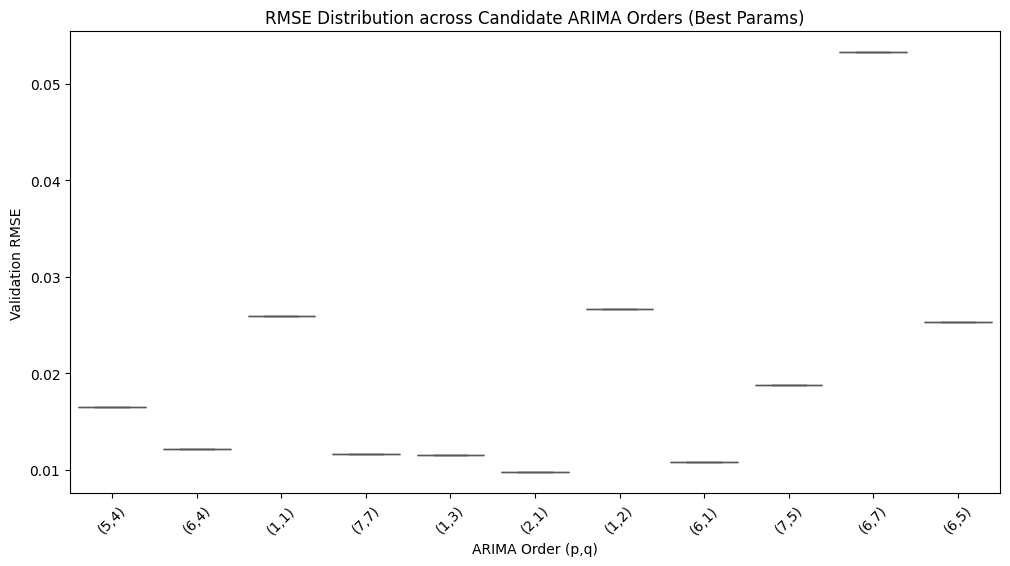

In [18]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# Load Tier-1 CSV
df = pd.read_csv("data/tuning_results/csv/tier1_arima.csv")

# Parse dict string trong best_params
df["best_params"] = df["best_params"].apply(ast.literal_eval)
df["p"] = df["best_params"].apply(lambda d: d.get("p", None))
df["q"] = df["best_params"].apply(lambda d: d.get("q", None))
df["order"] = df.apply(lambda r: f"({r['p']},{r['q']})", axis=1)

# Vẽ boxplot RMSE theo order
plt.figure(figsize=(12,6))
sns.boxplot(x="order", y="rmse", data=df, palette="Set2")
plt.xticks(rotation=45)
plt.title("RMSE Distribution across Candidate ARIMA Orders (Best Params)")
plt.xlabel("ARIMA Order (p,q)")
plt.ylabel("Validation RMSE")
plt.show()

/var/folders/6d/n0c7d2jd30sb50l09f4d_qsm0000gn/T/ipykernel_2494/2120198096.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="order", y="rmse", data=df_cand, palette="Set3")


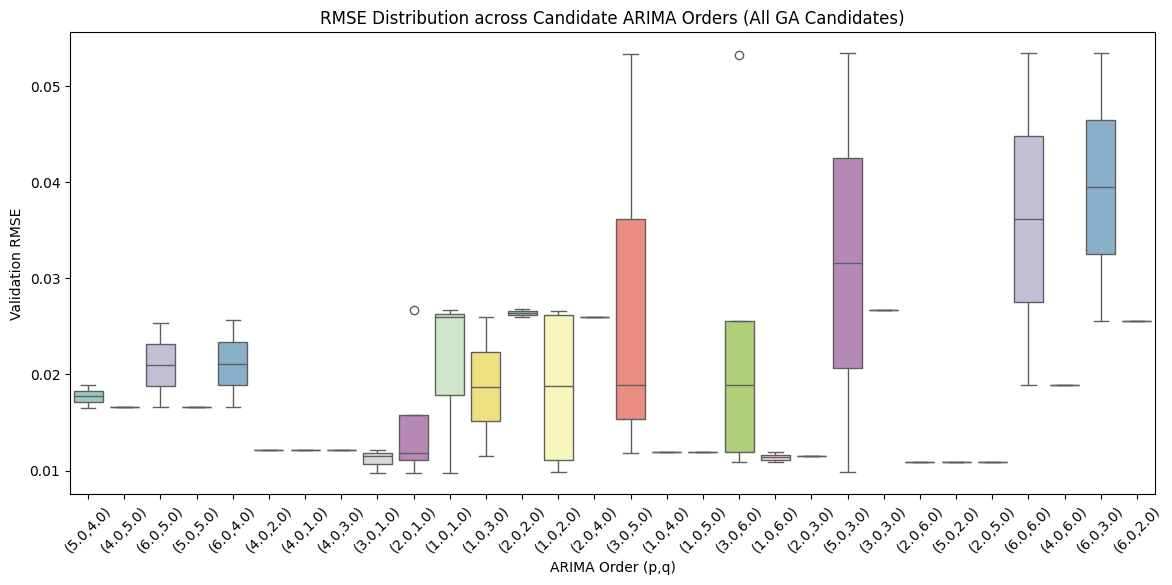

In [19]:
rows = []
for _, row in df.iterrows():
    fold_id = row["fold_id"]
    candidates = ast.literal_eval(row["top_ga"])
    for cand in candidates:
        rows.append({
            "fold_id": fold_id,
            "p": cand["p"],
            "q": cand["q"],
            "rmse": cand["rmse"]
        })

df_cand = pd.DataFrame(rows)
df_cand["order"] = df_cand.apply(lambda r: f"({r['p']},{r['q']})", axis=1)

plt.figure(figsize=(14,6))
sns.boxplot(x="order", y="rmse", data=df_cand, palette="Set3")
plt.xticks(rotation=45)
plt.title("RMSE Distribution across Candidate ARIMA Orders (All GA Candidates)")
plt.xlabel("ARIMA Order (p,q)")
plt.ylabel("Validation RMSE")
plt.show()

python baseline_rs_arima_tier2.py \
  --folds-json data/processed_folds/final/arima/arima_tuning_folds_final_paths.json \
  --tier1-json  data/tuning_results/jsons/tier1_arima.json \
  --retrain-intervals 10,20,42 \
  --budget 60 \
  --out-front-csv data/tuning_results/csv/tier2_arima_rs_front.csv

python baseline_rwd.py \
  --t1-csv data/tuning_results/csv/tier1_arima.csv \
  --folds-json data/processed_folds/final/arima/arima_tuning_folds_final_paths.json \
  --train-key train_path_arima --val-key val_path_arima --col Log_Returns \
  --out-csv results/baselines/tier1_arima_with_rwd.csv

python baseline_rwd.py \
  --t1-csv data/tuning_results/csv/tier1_lstm.csv \
  --folds-json data/processed_folds/final/lstm/lstm_tuning_folds_final_paths.json \
  --train-key train_path_lstm --val-key val_path_lstm --col target \
  --out-csv results/baselines/tier1_lstm_with_rwd.csv

python baseline_rs_lstm_tier2.py \
  --folds-json data/processed_folds/final/lstm/lstm_tuning_folds_final_paths.json \
  --tier1-json  data/tuning_results/jsons/tier1_lstm_backbone.json \
  --retrain-intervals 10,20,42 \
  --budget 60 \
  --out-front-csv data/tuning_results/csv/tier2_lstm_rs_front.csv

# ARIMA
python mini_summary_mdd_vol_turnover.py \
  --mode arima \
  --csv data/results/backtest_arima.csv \
  --outdir results/chap5/risk_summaries \
  --split-by-source --plot-turnover

# LSTM
python mini_summary_mdd_vol_turnover.py \
  --mode lstm \
  --csv data/results/backtest_lstm.csv \
  --outdir results/chap5/risk_summaries \
  --split-by-source --plot-turnover

In [2]:
pip install tabulate

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

compare = pd.read_csv("data/scaled/global/scaling_summary_compare.csv")

# Pick representative features
selected = ["Transformed_Close","Transformed_Volume","RSI_14","SMA_5","BB_Upper_20_2Std"]
table = compare[compare["feature"].isin(selected)]

print(table.to_markdown(index=False))

| feature            | group                |    min_raw |   max_raw |   mean_raw |   std_raw |   min_scaled |   max_scaled |   mean_scaled |   std_scaled |
|:-------------------|:---------------------|-----------:|----------:|-----------:|----------:|-------------:|-------------:|--------------:|-------------:|
| BB_Upper_20_2Std   | Indicators (Z-score) |  0.241951  | 229.668   |   37.8899  | 41.9725   |    -0.896993 |      4.56927 |  -8.5623e-19  |     1.00003  |
| RSI_14             | Indicators (Z-score) |  0.0438411 |  99.9974  |   55.0449  | 16.7535   |    -3.28306  |      2.68325 |  -5.1331e-16  |     1.00003  |
| SMA_5              | Indicators (Z-score) |  0.23429   | 210.386   |   36.1101  | 40.1      |    -0.894686 |      4.34617 |   2.00358e-16 |     1.00003  |
| Transformed_Close  | OHLCV (MinMax)       | -1.2194    |  11.251   |    4.62458 |  2.84115  |     0        |      1       |   0.468628    |     0.227831 |
| Transformed_Volume | OHLCV (MinMax)       |  6.98622   |

python analyze_backtest_results_lstm.py viz \
  --test-csv data/processed_folds/final/lstm/test/lstm_test_scaled.csv \
  --interval 10 --fold-id 206 \
  --use-backtest --backtest-csv data/backtest_lstm/backtest_lstm_results.csv \
  --source-label GA+BO_knee \
  --layers 1 --batch-size 32 --dropout 0.2 --patience 5 \
  --outdir viz_outputs/f206_int10
# (tùy chọn) nếu không dùng GPU/mixed precision
# --no-mixed-precision

python analyze_backtest_results_lstm.py turnover \
  --test-csv data/processed_folds/final/lstm/test/lstm_test_scaled.csv \
  --interval 20 --fold-id 206 \
  --use-backtest --backtest-csv data/backtest_lstm/backtest_lstm_results.csv \
  --source-label GA+BO_knee \
  --layers 1 --batch-size 32 --dropout 0.2 --patience 5 \
  --turnover-window 21 --annualize-turnover \
  --outdir turnover_outputs/f206_int20

python analyze_backtest.py sensitivity \
  --test-csv data/processed_folds/final/lstm/test/lstm_test_scaled.csv \
  --interval 20 --fold-id 206 \
  --use-backtest --backtest-csv data/backtest_lstm/backtest_lstm_results.csv \
  --source-label GA+BO_knee \
  --layers 1 --batch-size 32 --dropout 0.2 --patience 5 \
  --cost-mults 0.5,1.0,1.5 --thr-mults 0.9,1.0,1.1 --plot \
  --outdir sensitivity_outputs/f206_int20

python analyze_backtest.py cumret \
  --test-csv data/processed_folds/final/lstm/test/lstm_test_scaled.csv \
  --interval 20 --fold-id 206 \
  --use-backtest --backtest-csv data/backtest_lstm/backtest_lstm_results.csv \
  --source-label GA+BO_knee \
  --layers 1 --batch-size 32 --dropout 0.2 --patience 5 \
  --write-csv \
  --outdir cumret_outputs/f206_int20

python analyze_backtest.py viz \
  --test-csv data/processed_folds/final/lstm/test/lstm_test_scaled.csv \
  --interval 20 --fold-id 206 \
  --use-backtest --backtest-csv data/backtest_lstm/backtest_lstm_results.csv \
  --source-label GA+BO_knee \
  --layers 1 --batch-size 32 --dropout 0.2 --patience 5 \
  --outdir viz_outputs/f206_int20
# (tùy chọn) nếu không dùng GPU/mixed precision
# --no-mixed-precision

python aggregate_backtests_lstm.py \
  --backtest-csv data/backtest_lstm/backtest_lstm_results.csv \
  --test-csv data/processed_folds/final/lstm/test/lstm_test_scaled.csv \
  --tier1-json data/tuning_results/jsons/tier1_lstm_backbone.json \
  --intervals 10,20,42 \
  --source-label GA+BO_knee \
  --outdir agg_plots_lstm \
  --no-mean-equity

python aggregate_backtests_lstm.py \
  --backtest-csv data/backtest_lstm/backtest_lstm_results.csv \
  --test-csv data/processed_folds/final/lstm/test/lstm_test_scaled.csv \
  --tier1-json data/tuning_results/jsons/tier1_lstm.json \
  --intervals 10,20,42 \
  --source-label GA+BO_knee \
  --outdir agg_plots_lstm \
  --max-rows-per-plot 120

python analyze_backtest_results_arima.py viz \
  --use-backtest \
  --backtest-csv data/backtest_arima/backtest_arima_results.csv \
  --source-label GA+BO_knee \
  --test-csv data/processed_folds/final/arima/test/arima_test_scaled.csv \
  --fold-id 584 \
  --interval 20 \
  --outdir viz_outputs/arima/fold_584_20 \
  --window 63 \
  --turnover-window 21 \
  --annualize-turnover


python analyze_backtest_results_arima.py turnover \
  --use-backtest \
  --backtest-csv data/backtest_arima/backtest_arima_results.csv \
  --source-label GA+BO_knee \
  --test-csv data/processed_folds/final/arima/test/arima_test_scaled.csv \
  --fold-id 35 \
  --interval 10 \
  --outdir turnover_outputs/arima/fold_35_10 \
  --turnover-window 21 \
  --annualize-turnover  

python analyze_backtest_results_arima.py vol \
  --use-backtest \
  --backtest-csv data/backtest_arima/backtest_arima_results.csv \
  --source-label GA+BO_knee \
  --test-csv data/processed_folds/final/arima/test/arima_test_scaled.csv \
  --fold-id 444 \
  --interval 10 \
  --outdir volatility/arima/fold_444_10 \
  --window 63 \
  --periods-per-year 252

python analyze_backtest_results_arima.py cumret \
  --use-backtest \
  --backtest-csv data/backtest_arima/backtest_arima_results.csv \
  --source-label GA+BO_knee \
  --test-csv data/processed_folds/final/arima/test/arima_test_scaled.csv \
  --fold-id 35 \
  --interval 10 \
  --outdir cumret_outputs/arima/fold_35_10

python analyze_backtest_results_arima.py sensitivity \
  --use-backtest \
  --backtest-csv data/backtest_arima/backtest_arima_results.csv \
  --source-label GA+BO_knee \
  --test-csv data/processed_folds/final/arima/test/arima_test_scaled.csv \
  --fold-id 80 \
  --interval 42 \
  --outdir sensitivity_outputs/arima/fold_80_42 \
  --plot

python analyze_backtest_results_lstm.py viz \
  --use-backtest \
  --backtest-csv data/backtest_lstm/backtest_lstm_results.csv \
  --source-label GA+BO_knee \
  --test-csv data/processed_folds/final/lstm/test/lstm_test_scaled.csv \
  --fold-id 3 \
  --interval 42 \
  --outdir viz_outputs/arima/fold_3_42 \
  --window 63 \
  --turnover-window 21 \
  --annualize-turnover

python analyze_backtest_results_lstm.py cumret \
  --use-backtest \
  --backtest-csv data/backtest_lstm/backtest_lstm_results.csv \
  --test-csv data/processed_folds/final/lstm/test/lstm_test_scaled.csv \
  --fold-id 35 \
  --interval 42 \
  --outdir cumret_outputs/lstm/fold_35_42